**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
from numpy import linalg
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N
    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********


# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

#*******
# TODO: Test this function
#*******

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_init, targ_vect)= brain_vars
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, brain_vars)
    

    num_neurons = np.size(fr_init, 0)
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, 1, num_iter) )
        fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
#         fr_vect[:, 0] = fr_init
        fr_final = np.zeros((num_neurons, 1, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str( fr_vect[:, :, 0] ))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, :, iT+1] = fr_next

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            brain_vars_next = fr_next, targ_vect
            grad_args_next = (decoder_init, brain_vars_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next

            # (4) calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, :, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next        

    return (re_final, fr_final, lambda_final)

In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
# TARGET_VECTOR = np.array([[1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (10*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (-np.matmul(K_MATX, BASELINE))
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

KW_only = False

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 0*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)

# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[1.39050741 4.50749211 4.96603335 5.77415931 0.15015408 8.72027511
 7.75313826 6.67757535 5.04622559 3.46002014]
K MATX = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]
A = [-17.6655621  -25.70217546]
lambda init = 
[[ 1.39050741e+00 -2.19998086e-01  3.80860538e-01]
 [ 4.50749211e+00 -1.92425122e-01  4.00253626e-01]
 [ 4.96603335e+00  4.50770713e-03  4.04018191e-02]
 [ 5.77415931e+00  2.89709297e-01 -1.17421174e-02]
 [ 1.50154079e-01  5.20606846e-01 -2.34798652e-01]
 [ 8.72027511e+00 -2.07164093e-01  2.94486551e-01]
 [ 7.75313826e+00  4.61407514e-02  2.09791194e-01]
 [ 6.67757535e+00  7.87805923e-02  1.16036633e-01]
 [ 5.04622559e+00  4.30025834e-01 -1.51433718e-01]
 [ 3.46002014e+00 -1.95715600e-01  2.6699429

### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]
A VECT INIT = [-17.6655621  -25.70217546]
lambda
[[ 1.39050741e+00 -2.19998086e-01  3.80860538e-01]
 [ 4.50749211e+00 -1.92425122e-01  4.00253626e-01]
 [ 4.96603335e+00  4.50770713e-03  4.04018191e-02]
 [ 5.77415931e+00  2.89709297e-01 -1.17421174e-02]
 [ 1.50154079e-01  5.20606846e-01 -2.34798652e-01]
 [ 8.72027511e+00 -2.07164093e-01  2.94486551e-01]
 [ 7.75313826e+00  4.61407514e-02  2.09791194e-01]
 [ 6.67757535e+00  7.87805923e-02  1.16036633e-01]
 [ 5.04622559e+00  4.30025834e-01 -1.51433718e-01]
 [ 3.46002014e+00 -1.95715600e-01  2.66994298e-01]]
a
[-17.6655621  -25.70217546]
K
[[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.

lambda end of trial = [[ 1.39015836e+00 -2.27393802e-01  3.91000971e-01]
 [ 4.50586293e+00 -1.95414257e-01  3.99480387e-01]
 [ 4.96324584e+00 -7.89057118e-04  2.12698891e-02]
 [ 5.77150461e+00  2.95583176e-01 -3.59362199e-03]
 [ 1.53866156e-01  5.38482336e-01 -2.07517723e-01]
 [ 8.72146141e+00 -2.01914984e-01  2.99668565e-01]
 [ 7.75026486e+00  3.59567988e-02  2.14182162e-01]
 [ 6.67936490e+00  1.00209369e-01  1.29301525e-01]
 [ 5.04196889e+00  4.14671018e-01 -1.63006942e-01]
 [ 3.45884428e+00 -1.93608850e-01  2.63699957e-01]]
cursor end = [[2.04376272]
 [1.01960746]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #9 | lambda learn rate = 0.005
Target = [[3.]
 [7.]]
cursor start = [[3.22618343]
 [7.16021485]]
lambda end of trial = [[ 1.39034561e+00 -2.26832047e-0

lambda end of trial = [[ 1.38915976 -0.23811111  0.36903608]
 [ 4.50779337 -0.17729716  0.41590212]
 [ 4.96712399  0.02027893  0.04572292]
 [ 5.77333925  0.2911179   0.01625198]
 [ 0.15223302  0.52273303 -0.20826993]
 [ 8.72160288 -0.18596834  0.30702885]
 [ 7.75180312  0.03101641  0.21448233]
 [ 6.6796632   0.10103319  0.13064816]
 [ 5.04134468  0.40657457 -0.1684678 ]
 [ 3.45806311 -0.1951708   0.25885312]]
cursor end = [[8.93497985]
 [1.08422364]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #20 | lambda learn rate = 0.005
Target = [[0.]
 [7.]]
cursor start = [[0.29283825]
 [7.24255357]]
lambda end of trial = [[ 1.38941992 -0.23811111  0.37085718]
 [ 4.50754207 -0.17729716  0.41414306]
 [ 4.96625441  0.02027893  0.03963584]
 [ 5.77280144  0.2911179   0.01248

cursor start = [[5.93290458]
 [2.01173015]]
lambda end of trial = [[ 1.39132023e+00 -2.34627024e-01  3.72009770e-01]
 [ 4.50885141e+00 -1.74445759e-01  4.10258885e-01]
 [ 4.96811138e+00  2.09661856e-02  3.30683271e-02]
 [ 5.77213603e+00  2.81338491e-01  6.18752036e-03]
 [ 1.52746506e-01  5.32164560e-01 -2.07670548e-01]
 [ 8.72042987e+00 -1.90423162e-01  2.96922058e-01]
 [ 7.75294165e+00  3.06016225e-02  2.04984837e-01]
 [ 6.67955712e+00  9.16558138e-02  1.26342145e-01]
 [ 5.03875640e+00  3.86076735e-01 -1.69804000e-01]
 [ 3.45721389e+00 -1.94535286e-01  2.59224218e-01]]
cursor end = [[5.86478301]
 [1.98380983]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #29 | lambda learn rate = 0.005
Target = [[6.]
 [2.]]
cursor start = [[5.86478301]
 [1.98380983]]
lambda en

lambda end of trial = [[ 1.38840067 -0.24663069  0.35810024]
 [ 4.50426585 -0.18023075  0.3805952 ]
 [ 4.97165044  0.03753019  0.0475121 ]
 [ 5.77000524  0.28348928 -0.01255281]
 [ 0.15136387  0.53362922 -0.21032335]
 [ 8.72503303 -0.16648702  0.31505506]
 [ 7.75363865  0.03868358  0.21813129]
 [ 6.67243437  0.07240893  0.06916274]
 [ 5.03830786  0.39394359 -0.16966295]
 [ 3.45764438 -0.19112421  0.26503787]]
cursor end = [[4.78957119]
 [3.80567712]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #40 | lambda learn rate = 0.005
Target = [[5.]
 [7.]]
cursor start = [[4.73801339]
 [6.68058279]]
lambda end of trial = [[ 1.38838593 -0.24670438  0.35799708]
 [ 4.50430027 -0.18005866  0.38083612]
 [ 4.97206776  0.03961677  0.05043331]
 [ 5.76941184  0.28052229 -0.01670

 [ 3.45629343e+00 -2.01426992e-01  2.59053910e-01]]
cursor end = [[1.10414275]
 [6.08052216]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #50 | lambda learn rate = 0.005
Target = [[3.]
 [8.]]
cursor start = [[3.17484175]
 [8.18402647]]
lambda end of trial = [[ 1.39503705e+00 -2.15421867e-01  4.01095119e-01]
 [ 4.50435458e+00 -1.75482655e-01  3.79299585e-01]
 [ 4.97015251e+00  3.23987518e-02  4.58401445e-02]
 [ 5.77239347e+00  2.94962978e-01  1.78615252e-03]
 [ 1.54371155e-01  5.58615399e-01 -1.98610830e-01]
 [ 8.72510781e+00 -1.61695712e-01  3.28714550e-01]
 [ 7.75776099e+00  5.84485644e-02  2.40685022e-01]
 [ 6.67243003e+00  7.65343634e-02  6.79564555e-02]
 [ 5.03666015e+00  3.88428330e-01 -1.86425354e-01]
 [ 3.45635362e+00 -2.01246430e-01  2.59535409e-01]]
c

lambda end of trial = [[ 1.39168948e+00 -2.35693482e-01  3.83553322e-01]
 [ 4.49952713e+00 -1.86026732e-01  3.64396423e-01]
 [ 4.96763054e+00  2.61743247e-02  2.97651426e-02]
 [ 5.77401472e+00  2.96491923e-01  6.16292669e-03]
 [ 1.56700916e-01  5.58065854e-01 -1.86992552e-01]
 [ 8.72569639e+00 -1.46857414e-01  3.41645020e-01]
 [ 7.75781789e+00  7.38093960e-02  2.55466007e-01]
 [ 6.67088735e+00  6.98848663e-02  5.50249997e-02]
 [ 5.03156562e+00  3.79538926e-01 -2.07171639e-01]
 [ 3.45398563e+00 -2.02222781e-01  2.52919640e-01]]
cursor end = [[0.9979241 ]
 [3.99638189]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #62 | lambda learn rate = 0.005
Target = [[5.]
 [7.]]
cursor start = [[5.03714469]
 [7.11830643]]
lambda end of trial = [[ 1.39132656e+00 -2.37508084e-

lambda end of trial = [[ 1.39246462 -0.24282927  0.38660898]
 [ 4.49994162 -0.18307938  0.3737677 ]
 [ 4.96668891  0.01965595  0.03358437]
 [ 5.77560068  0.31431817  0.02004394]
 [ 0.15445811  0.56585167 -0.20186454]
 [ 8.72663776 -0.13095145  0.34147669]
 [ 7.75679368  0.07536619  0.2516597 ]
 [ 6.67200164  0.0756146   0.05883388]
 [ 5.03178785  0.37977483 -0.20203735]
 [ 3.45164076 -0.21292076  0.24318017]]
cursor end = [[0.01128938]
 [7.01193401]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #74 | lambda learn rate = 0.005
Target = [[1.]
 [6.]]
cursor start = [[1.04198489]
 [6.0604834 ]]
lambda end of trial = [[ 1.39226868 -0.24302521  0.3854333 ]
 [ 4.5007155  -0.18230551  0.37841094]
 [ 4.96664843  0.01961547  0.03334151]
 [ 5.77569875  0.31441624  0.02063

lambda end of trial = [[ 1.39333749 -0.24555376  0.37721312]
 [ 4.50175663 -0.176477    0.37847385]
 [ 4.96502893  0.01488229  0.02297351]
 [ 5.77563105  0.31298211  0.01106898]
 [ 0.1585141   0.59637924 -0.17087328]
 [ 8.72820714 -0.14987751  0.36070349]
 [ 7.75333604  0.06607717  0.23607925]
 [ 6.67343854  0.06894455  0.06609039]
 [ 5.03313295  0.39802907 -0.1942888 ]
 [ 3.45542348 -0.17330106  0.26915547]]
cursor end = [[9.80951509]
 [8.74863942]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #86 | lambda learn rate = 0.005
Target = [[5.]
 [8.]]
cursor start = [[5.53701492]
 [8.48144311]]
lambda end of trial = [[ 1.39177660e+00 -2.53358209e-01  3.64726003e-01]
 [ 4.49924853e+00 -1.89017525e-01  3.58409014e-01]
 [ 4.96364276e+00  7.95144392e-03  1.18841586e-02

lambda end of trial = [[ 1.39516894e+00 -2.38120663e-01  3.85232919e-01]
 [ 4.50122575e+00 -1.86676720e-01  3.66455192e-01]
 [ 4.96543701e+00  6.46486036e-03  1.95319555e-02]
 [ 5.77171225e+00  2.80575691e-01 -1.71735757e-02]
 [ 1.57046216e-01  5.87611774e-01 -1.84297587e-01]
 [ 8.72861197e+00 -1.57025428e-01  3.66066154e-01]
 [ 7.75878246e+00  8.10047399e-02  2.63347865e-01]
 [ 6.66805502e+00  3.95054613e-02  2.86221011e-02]
 [ 5.03330744e+00  3.78716616e-01 -1.99828306e-01]
 [ 3.45344080e+00 -1.85347874e-01  2.50098370e-01]]
cursor end = [[7.96712927]
 [8.08816104]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #95 | lambda learn rate = 0.005
Target = [[4.]
 [9.]]
cursor start = [[3.89847858]
 [8.98531615]]
lambda end of trial = [[ 1.39579499e+00 -2.35616470e-

lambda end of trial = [[ 1.39440870e+00 -2.51181862e-01  3.82076307e-01]
 [ 4.50228239e+00 -1.86992865e-01  3.52301964e-01]
 [ 4.96707509e+00  1.40907818e-03  3.41493927e-02]
 [ 5.76896635e+00  2.47985733e-01 -3.50275699e-02]
 [ 1.58788007e-01  5.78397577e-01 -1.74919527e-01]
 [ 8.72415520e+00 -1.75163005e-01  3.38386451e-01]
 [ 7.75792235e+00  6.55546306e-02  2.58588779e-01]
 [ 6.67215562e+00  5.34506482e-02  4.20788644e-02]
 [ 5.03005912e+00  3.66066539e-01 -2.37683815e-01]
 [ 3.45596627e+00 -1.73025434e-01  2.59422403e-01]]
cursor end = [[6.53602978]
 [3.64815177]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #108 | lambda learn rate = 0.005
Target = [[3.]
 [5.]]
cursor start = [[2.62249226]
 [4.67782973]]
lambda end of trial = [[ 1.39611949e+00 -2.46049489e

lambda end of trial = [[ 1.40006623 -0.22869862  0.40553891]
 [ 4.49823044 -0.20043017  0.32103101]
 [ 4.97177691  0.02200659  0.07314324]
 [ 5.77360428  0.27118439 -0.02006274]
 [ 0.15986848  0.5795018  -0.17119267]
 [ 8.7221351  -0.18871259  0.32963055]
 [ 7.76455542  0.10877177  0.28665851]
 [ 6.67400722  0.0630663   0.03983727]
 [ 5.03296882  0.39078562 -0.23535325]
 [ 3.45888277 -0.15605207  0.26174091]]
cursor end = [[8.20979605]
 [2.32097315]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #121 | lambda learn rate = 0.005
Target = [[5.]
 [1.]]
cursor start = [[5.13768753]
 [1.20967383]]
lambda end of trial = [[ 1.40115459 -0.22325683  0.40662726]
 [ 4.49907812 -0.19619178  0.32187869]
 [ 4.97391612  0.03270264  0.07528246]
 [ 5.77494536  0.27788979 -0.0187

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #133 | lambda learn rate = 0.005
Target = [[1.]
 [8.]]
cursor start = [[0.57578465]
 [7.43125292]]
lambda end of trial = [[ 1.39777681 -0.23279502  0.39994809]
 [ 4.49354857 -0.21767814  0.30742028]
 [ 4.97335603  0.0233792   0.07510141]
 [ 5.77384186  0.26550464 -0.01842776]
 [ 0.15771087  0.56641846 -0.18348212]
 [ 8.72075158 -0.18414659  0.33500167]
 [ 7.76533286  0.10033798  0.30503758]
 [ 6.67324567  0.06734584  0.0475607 ]
 [ 5.03303691  0.37777311 -0.23183192]
 [ 3.4553812  -0.16517131  0.24527721]]
cursor end = [[0.81614967]
 [7.74025909]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #134 | lambda learn rate = 0.005
Target = [[8.]
 [0.]]
cursor start = [[7.97880191]
 [0.09125122]]
lambda end of tria

 [ 3.4583285  -0.14991391  0.25637907]]
cursor end = [[3.91783951]
 [3.05309639]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #145 | lambda learn rate = 0.005
Target = [[6.]
 [0.]]
cursor start = [[6.0257157 ]
 [0.17668596]]
lambda end of trial = [[ 1.40043186 -0.22202064  0.41055135]
 [ 4.49311248 -0.23042675  0.31360111]
 [ 4.97182964  0.01761909  0.06981095]
 [ 5.77608587  0.27900548 -0.01358898]
 [ 0.15726056  0.56979823 -0.17793789]
 [ 8.72216587 -0.17752556  0.3432259 ]
 [ 7.7631126   0.08611099  0.30109309]
 [ 6.67236454  0.05475731  0.04002917]
 [ 5.0275098   0.35849932 -0.25224471]
 [ 3.45769014 -0.15374404  0.25637907]]
cursor end = [[5.87182641e+00]
 [1.01804646e-03]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 

 [ 3.4582417  -0.15281464  0.25283995]]
cursor end = [[5.82204246]
 [1.85275373]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #157 | lambda learn rate = 0.005
Target = [[9.]
 [6.]]
cursor start = [[8.613522  ]
 [5.69092267]]
lambda end of trial = [[ 1.40502506 -0.20660785  0.43496238]
 [ 4.49229293 -0.2566607   0.30785341]
 [ 4.97147635  0.01913986  0.08131735]
 [ 5.77236058  0.27301225 -0.03662498]
 [ 0.15743738  0.582897   -0.17873917]
 [ 8.72408196 -0.1715911   0.35124385]
 [ 7.76535191  0.11534304  0.31059699]
 [ 6.67350197  0.07363352  0.03786457]
 [ 5.03345856  0.38514182 -0.21528768]
 [ 3.45799799 -0.15500803  0.25137768]]
cursor end = [[9.18025865]
 [6.31909096]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

 [ 3.45506394 -0.16053802  0.2376278 ]]
cursor end = [[0.91756237]
 [8.74217701]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #170 | lambda learn rate = 0.005
Target = [[1.]
 [2.]]
cursor start = [[0.98173029]
 [1.94208698]]
lambda end of trial = [[ 1.40388146 -0.21278148  0.43408748]
 [ 4.48713301 -0.27738401  0.27794726]
 [ 4.97230877  0.01955234  0.09234144]
 [ 5.77494647  0.2777837  -0.03173185]
 [ 0.15887008  0.57636755 -0.17304863]
 [ 8.72310434 -0.17262728  0.3450233 ]
 [ 7.76717228  0.12141576  0.31692506]
 [ 6.67098687  0.06434519  0.02165404]
 [ 5.03560827  0.3651643  -0.20468586]
 [ 3.45516909 -0.16043287  0.23783808]]
cursor end = [[0.99163357]
 [1.94396133]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

lambda end of trial = [[ 1.40521325e+00 -2.10502993e-01  4.47824820e-01]
 [ 4.48935740e+00 -2.80464653e-01  2.94418933e-01]
 [ 4.96841643e+00  7.56848805e-04  7.52245697e-02]
 [ 5.78048227e+00  2.88636848e-01 -2.11453980e-02]
 [ 1.63726985e-01  5.80633325e-01 -1.65965094e-01]
 [ 8.72371082e+00 -1.72319039e-01  3.67764284e-01]
 [ 7.76331651e+00  1.06819449e-01  2.93023935e-01]
 [ 6.67057194e+00  6.31654268e-02  1.76778071e-02]
 [ 5.03581905e+00  3.68986650e-01 -2.21433435e-01]
 [ 3.45302650e+00 -1.70079158e-01  2.35756564e-01]]
cursor end = [[4.91473296]
 [8.83639894]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #183 | lambda learn rate = 0.005
Target = [[3.]
 [7.]]
cursor start = [[2.92977973]
 [6.88154004]]
lambda end of trial = [[ 1.40638913e+00 -2.06975356e

lambda end of trial = [[ 1.40818988 -0.19438367  0.45977084]
 [ 4.48726306 -0.29674473  0.28601975]
 [ 4.96544929 -0.00888367  0.0447621 ]
 [ 5.7770326   0.26652137 -0.03600306]
 [ 0.16627459  0.58599703 -0.14472408]
 [ 8.72079527 -0.19601574  0.34930627]
 [ 7.75957067  0.0840208   0.27652036]
 [ 6.672237    0.05668556  0.03403506]
 [ 5.03566132  0.36428322 -0.21428472]
 [ 3.45634562 -0.14534979  0.24800156]]
cursor end = [[1.90783806]
 [8.70455362]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #195 | lambda learn rate = 0.005
Target = [[9.]
 [5.]]
cursor start = [[8.7405311 ]
 [4.47423624]]
lambda end of trial = [[ 1.41025382e+00 -1.75808189e-01  4.70090556e-01]
 [ 4.49021169e+00 -2.70207002e-01  3.00762928e-01]
 [ 4.96581815e+00 -5.56392957e-03  4.66064039e-0

 [ 3.45727871 -0.12850305  0.26217032]]
cursor end = [[7.1168131 ]
 [2.08586773]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #207 | lambda learn rate = 0.005
Target = [[8.]
 [1.]]
cursor start = [[8.11706715]
 [1.09244497]]
lambda end of trial = [[ 1.41369261 -0.16580212  0.47169238]
 [ 4.49357399 -0.2538512   0.30761362]
 [ 4.96290414 -0.01993803  0.04184014]
 [ 5.7780101   0.28794361 -0.02057551]
 [ 0.16396322  0.59357005 -0.15311506]
 [ 8.71674056 -0.20721741  0.32960835]
 [ 7.75733927  0.08364179  0.26411251]
 [ 6.67241212  0.04900997  0.04190042]
 [ 5.03721328  0.36329996 -0.20397369]
 [ 3.45772309 -0.12494802  0.2626147 ]]
cursor end = [[8.07151257]
 [1.20141318]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

lambda end of trial = [[ 1.41550862e+00 -1.61672555e-01  4.88470558e-01]
 [ 4.49426863e+00 -2.60626361e-01  2.94723225e-01]
 [ 4.95791224e+00 -2.51473203e-02  1.72892350e-02]
 [ 5.78134596e+00  3.06383771e-01 -7.02574087e-03]
 [ 1.64821114e-01  6.02688357e-01 -1.51477863e-01]
 [ 8.71796788e+00 -2.05741398e-01  3.38116624e-01]
 [ 7.75687625e+00  7.98568580e-02  2.52195553e-01]
 [ 6.67368157e+00  5.31766939e-02  4.86115982e-02]
 [ 5.03770196e+00  3.75239935e-01 -2.08287514e-01]
 [ 3.45345388e+00 -1.50906626e-01  2.20927253e-01]]
cursor end = [[1.11080655]
 [4.98353575]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #219 | lambda learn rate = 0.005
Target = [[2.]
 [6.]]
cursor start = [[2.15969212]
 [5.99893583]]
lambda end of trial = [[ 1.41413569 -0.1644184   0.4

lambda end of trial = [[ 1.41210891e+00 -1.71863012e-01  4.99541624e-01]
 [ 4.49162302e+00 -2.95638775e-01  2.89873820e-01]
 [ 4.95793961e+00 -2.04677575e-02  2.40139124e-02]
 [ 5.78105197e+00  3.06365344e-01 -2.67409250e-03]
 [ 1.61751275e-01  5.89459520e-01 -1.47090468e-01]
 [ 8.72192837e+00 -1.90938355e-01  3.59512356e-01]
 [ 7.75509765e+00  7.00989683e-02  2.40262072e-01]
 [ 6.67643725e+00  6.92225524e-02  5.39738849e-02]
 [ 5.03329612e+00  3.63924439e-01 -2.20819143e-01]
 [ 3.45347937e+00 -1.55797345e-01  2.18535185e-01]]
cursor end = [[3.0442585 ]
 [2.95537128]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #233 | lambda learn rate = 0.005
Target = [[2.]
 [2.]]
cursor start = [[2.03078305]
 [1.97104148]]
lambda end of trial = [[ 1.41328396e+00 -1.69512917e

lambda end of trial = [[ 1.41308776e+00 -1.72657306e-01  5.02224045e-01]
 [ 4.49363349e+00 -2.92954908e-01  3.04801222e-01]
 [ 4.95420837e+00 -4.29265160e-02  7.90985389e-03]
 [ 5.78250127e+00  3.02470444e-01  7.98437757e-03]
 [ 1.56783180e-01  5.55114091e-01 -1.67972578e-01]
 [ 8.72317092e+00 -1.77050843e-01  3.72451138e-01]
 [ 7.75963870e+00  8.49602322e-02  2.58094400e-01]
 [ 6.67612604e+00  6.33677336e-02  5.61629990e-02]
 [ 5.03408222e+00  3.51557784e-01 -2.19415257e-01]
 [ 3.45099590e+00 -1.62782836e-01  2.15211179e-01]]
cursor end = [[3.92487889]
 [5.08322888]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #244 | lambda learn rate = 0.005
Target = [[3.]
 [6.]]
cursor start = [[2.96939061]
 [6.13271137]]
lambda end of trial = [[ 1.41146756e+00 -1.77517892e

lambda end of trial = [[ 1.41078395e+00 -1.79417382e-01  4.93576320e-01]
 [ 4.49155566e+00 -2.97704922e-01  2.87403504e-01]
 [ 4.95380828e+00 -4.25052250e-02  4.02308280e-03]
 [ 5.78476298e+00  3.06060849e-01  1.67698286e-02]
 [ 1.60506545e-01  5.63572045e-01 -1.56001230e-01]
 [ 8.72108131e+00 -1.95492208e-01  3.73269300e-01]
 [ 7.75843454e+00  7.97211555e-02  2.55858464e-01]
 [ 6.67375419e+00  6.55877735e-02  3.51654615e-02]
 [ 5.03672702e+00  3.67391112e-01 -2.08625734e-01]
 [ 3.45564851e+00 -1.54353197e-01  2.32322372e-01]]
cursor end = [[6.98715595]
 [3.88247953]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #253 | lambda learn rate = 0.005
Target = [[6.]
 [7.]]
cursor start = [[6.06378056]
 [6.95667572]]
lambda end of trial = [[ 1.40996818 -0.18431203  0.4

lambda end of trial = [[ 1.41271921 -0.1604949   0.49216861]
 [ 4.49279368 -0.29253726  0.29082219]
 [ 4.96140041 -0.01176784  0.02767542]
 [ 5.78357295  0.30947067  0.01520395]
 [ 0.16154542  0.56090745 -0.14229941]
 [ 8.71961366 -0.2208695   0.35850124]
 [ 7.76128725  0.08655016  0.2586568 ]
 [ 6.67149185  0.05241885  0.03140951]
 [ 5.03392691  0.35666189 -0.21676676]
 [ 3.45723797 -0.14435811  0.23900084]]
cursor end = [[2.97799789]
 [0.97469602]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #264 | lambda learn rate = 0.005
Target = [[6.]
 [6.]]
cursor start = [[6.05767931]
 [6.00731052]]
lambda end of trial = [[ 1.41315583e+00 -1.57875191e-01  4.94788311e-01]
 [ 4.49344826e+00 -2.88609765e-01  2.94749685e-01]
 [ 4.96199202e+00 -8.21814173e-03  3.12251153e-0

lambda end of trial = [[ 1.41206300e+00 -1.65420814e-01  4.77094480e-01]
 [ 4.49505474e+00 -2.76155632e-01  2.95233032e-01]
 [ 4.95673283e+00 -2.79140484e-02 -4.08386075e-03]
 [ 5.78251228e+00  3.09943143e-01 -2.18743918e-03]
 [ 1.58404570e-01  5.57230989e-01 -1.45891415e-01]
 [ 8.71963923e+00 -2.05874903e-01  3.71832192e-01]
 [ 7.76192058e+00  1.13283265e-01  2.63904965e-01]
 [ 6.67160183e+00  5.65321541e-02  3.14852302e-02]
 [ 5.03251988e+00  3.76147020e-01 -2.27022198e-01]
 [ 3.45727185e+00 -1.44085069e-01  2.39038270e-01]]
cursor end = [[3.04922128]
 [4.09734723]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #277 | lambda learn rate = 0.005
Target = [[6.]
 [5.]]
cursor start = [[6.08891002]
 [5.18174976]]
lambda end of trial = [[ 1.41077241e+00 -1.73164364e

 [ 3.45788574 -0.13870696  0.24390561]]
cursor end = [[4.99963389]
 [9.12745573]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #288 | lambda learn rate = 0.005
Target = [[0.]
 [8.]]
cursor start = [[0.01094667]
 [8.05097189]]
lambda end of trial = [[ 1.41285098 -0.1663357   0.47793605]
 [ 4.49541357 -0.28031394  0.30276392]
 [ 4.95747706 -0.02239126 -0.02015177]
 [ 5.78179144  0.29829559 -0.01445768]
 [ 0.15624915  0.54117146 -0.15777391]
 [ 8.718985   -0.21460596  0.37122496]
 [ 7.762243    0.11226231  0.25855907]
 [ 6.6717317   0.05485025  0.03600009]
 [ 5.03673201  0.38860202 -0.20221935]
 [ 3.4571295  -0.13870696  0.23785571]]
cursor end = [[0.02641309]
 [8.03720018]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

lambda end of trial = [[ 1.39080689e+00 -2.19698613e-01  3.81160012e-01]
 [ 4.50856140e+00 -1.91355835e-01  4.01322914e-01]
 [ 4.96685045e+00  5.32481393e-03  4.12189259e-02]
 [ 5.77322082e+00  2.88770814e-01 -1.26805997e-02]
 [ 1.49019854e-01  5.19472621e-01 -2.35932877e-01]
 [ 8.72036689e+00 -2.07072310e-01  2.94578334e-01]
 [ 7.75416698e+00  4.71694653e-02  2.10819907e-01]
 [ 6.67787596e+00  7.90812026e-02  1.16337243e-01]
 [ 5.04718395e+00  4.30984191e-01 -1.50475360e-01]
 [ 3.46043129e+00 -1.95304454e-01  2.67405444e-01]]
cursor end = [[1.00051673]
 [1.00585215]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #1 | lambda learn rate = 0.005
Target = [[1.]
 [9.]]
cursor start = [[1.00189466]
 [9.02145787]]
lambda end of trial = [[ 1.39101870e+00 -2.19486802e-0

lambda end of trial = [[ 1.38954369 -0.22310795  0.3778758 ]
 [ 4.50595947 -0.21378465  0.38157222]
 [ 4.96813892  0.01282206  0.04807703]
 [ 5.7701256   0.26653445 -0.01309262]
 [ 0.15015781  0.52419891 -0.22155625]
 [ 8.71805655 -0.22163512  0.28769919]
 [ 7.74986136  0.03189016  0.1868134 ]
 [ 6.67750523  0.07885968  0.12385177]
 [ 5.05004208  0.44199011 -0.13765848]
 [ 3.46444194 -0.17849935  0.29064427]]
cursor end = [[7.92132473]
 [6.59430448]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #13 | lambda learn rate = 0.005
Target = [[2.]
 [0.]]
cursor start = [[ 1.9636556 ]
 [-0.07767691]]
lambda end of trial = [[ 1.38876348 -0.22466836  0.3778758 ]
 [ 4.50682183 -0.21205994  0.38157222]
 [ 4.96796948  0.01248318  0.04807703]
 [ 5.76991407  0.26611138 -0.013

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #25 | lambda learn rate = 0.005
Target = [[3.]
 [0.]]
cursor start = [[ 2.97830933]
 [-0.0195729 ]]
lambda end of trial = [[ 1.39087016 -0.2299479   0.38611985]
 [ 4.51093124 -0.19954866  0.39137065]
 [ 4.97340587  0.04260129  0.07053846]
 [ 5.77358131  0.27659879 -0.01167606]
 [ 0.14747316  0.5123818  -0.23664362]
 [ 8.71597983 -0.23981877  0.28076644]
 [ 7.7526444   0.03080303  0.18793859]
 [ 6.67779256  0.08787104  0.12614297]
 [ 5.0496133   0.44903171 -0.134348  ]
 [ 3.47152884 -0.1336068   0.32039435]]
cursor end = [[ 2.98289652]
 [-0.01204423]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #26 | lambda learn rate = 0.005
Target = [[3.]
 [3.]]
cursor start = [[3.00224838]
 [3.02387861]]
lambda end of tr

lambda end of trial = [[ 1.39399452 -0.21388144  0.38795427]
 [ 4.51227613 -0.20052564  0.39295894]
 [ 4.97561104  0.03985699  0.08829575]
 [ 5.77527615  0.25735401 -0.01965786]
 [ 0.1470487   0.52059735 -0.23741723]
 [ 8.71700605 -0.24217287  0.28839859]
 [ 7.75527708  0.03664845  0.19049119]
 [ 6.67578823  0.07876053  0.10205835]
 [ 5.0529548   0.46419068 -0.10561071]
 [ 3.46945665 -0.14006222  0.32283927]]
cursor end = [[7.16791617]
 [9.15707228]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #37 | lambda learn rate = 0.005
Target = [[1.]
 [9.]]
cursor start = [[1.16276859]
 [9.17043724]]
lambda end of trial = [[ 1.39219244 -0.21568351  0.37173561]
 [ 4.51111216 -0.20168961  0.38248315]
 [ 4.97441737  0.03866332  0.07755271]
 [ 5.77291354  0.2549914  -0.04092

lambda end of trial = [[ 1.38719706 -0.23930359  0.33697824]
 [ 4.51336778 -0.19279286  0.3907929 ]
 [ 4.9727574   0.02204364  0.06310968]
 [ 5.77348755  0.26650718 -0.0349335 ]
 [ 0.14599814  0.51966706 -0.2418296 ]
 [ 8.7146856  -0.25065826  0.27181968]
 [ 7.75371988  0.04296032  0.1713328 ]
 [ 6.67687602  0.07611005  0.11880248]
 [ 5.05458877  0.47746888 -0.09752106]
 [ 3.4728082  -0.13340034  0.35603193]]
cursor end = [[0.97583023]
 [7.7497364 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #49 | lambda learn rate = 0.005
Target = [[4.]
 [2.]]
cursor start = [[4.05725844]
 [1.92165507]]
lambda end of trial = [[ 1.38813401 -0.23555579  0.33885214]
 [ 4.5149747  -0.18636517  0.39400674]
 [ 4.97221742  0.01988372  0.06202972]
 [ 5.77552861  0.27467144 -0.03085

lambda end of trial = [[ 1.39438266 -0.20961938  0.36896048]
 [ 4.51654996 -0.19848997  0.40809226]
 [ 4.97214224  0.02988962  0.06322798]
 [ 5.77656337  0.26091786 -0.03072621]
 [ 0.14861369  0.52625044 -0.23815138]
 [ 8.71757024 -0.22755394  0.28907435]
 [ 7.75851467  0.0577238   0.18927973]
 [ 6.67785963  0.08203179  0.12569395]
 [ 5.05499908  0.48029313 -0.11008578]
 [ 3.47351879 -0.14413198  0.36112659]]
cursor end = [[9.39718458]
 [5.49835749]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #61 | lambda learn rate = 0.005
Target = [[5.]
 [7.]]
cursor start = [[5.28331786]
 [7.43240846]]
lambda end of trial = [[ 1.39327699 -0.21514772  0.36122081]
 [ 4.51372804 -0.21259961  0.38833877]
 [ 4.97132069  0.02578188  0.05747714]
 [ 5.77481518  0.25217695 -0.04296

lambda end of trial = [[ 1.39286387 -0.22170573  0.35313101]
 [ 4.51171542 -0.21624342  0.39076754]
 [ 4.97259872  0.02440193  0.07462945]
 [ 5.77621225  0.26347627 -0.03844484]
 [ 0.14299798  0.51912948 -0.2589538 ]
 [ 8.71556335 -0.23504931  0.28209601]
 [ 7.75943746  0.05814403  0.20128722]
 [ 6.67671368  0.07021163  0.10389883]
 [ 5.05393872  0.49331959 -0.10530688]
 [ 3.4722267  -0.1532847   0.33798364]]
cursor end = [[1.01854169]
 [0.99861632]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #73 | lambda learn rate = 0.005
Target = [[3.]
 [7.]]
cursor start = [[2.97551726]
 [6.90254943]]
lambda end of trial = [[ 1.3922054  -0.22368116  0.34852167]
 [ 4.51039328 -0.22020983  0.38151256]
 [ 4.97211449  0.02294924  0.07123985]
 [ 5.77647115  0.26425296 -0.03663

lambda end of trial = [[ 1.39357923 -0.22152524  0.36263545]
 [ 4.51215991 -0.21657852  0.39548473]
 [ 4.97577004  0.03458592  0.08612571]
 [ 5.77646734  0.26160075 -0.0297364 ]
 [ 0.13918451  0.49961111 -0.26373073]
 [ 8.71903038 -0.20715975  0.27803991]
 [ 7.7593587   0.04671801  0.20391036]
 [ 6.67485954  0.06276804  0.10775828]
 [ 5.05492499  0.49951186 -0.09793604]
 [ 3.47850779 -0.13104071  0.3503994 ]]
cursor end = [[7.05760844]
 [0.07418618]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #86 | lambda learn rate = 0.005
Target = [[3.]
 [9.]]
cursor start = [[3.01087062]
 [9.13813251]]
lambda end of trial = [[ 1.39383381 -0.22076151  0.36492664]
 [ 4.5129527  -0.21420015  0.40261984]
 [ 4.97685294  0.0378346   0.09587175]
 [ 5.77664326  0.26212849 -0.02815

lambda end of trial = [[ 1.39462084 -0.22705351  0.36880102]
 [ 4.50866369 -0.23252153  0.37019461]
 [ 4.97704177  0.04242511  0.09768908]
 [ 5.77200602  0.25034969 -0.05287375]
 [ 0.13430398  0.48795153 -0.28743377]
 [ 8.71941223 -0.20879155  0.27247484]
 [ 7.76019357  0.03677046  0.19688331]
 [ 6.67883192  0.07882361  0.13160872]
 [ 5.06198977  0.52277137 -0.05619376]
 [ 3.48191763 -0.11985519  0.3480532 ]]
cursor end = [[0.98862254]
 [4.98755077]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #96 | lambda learn rate = 0.005
Target = [[9.]
 [8.]]
cursor start = [[9.01903166]
 [7.93130994]]
lambda end of trial = [[ 1.39515759 -0.22222274  0.37309504]
 [ 4.51053455 -0.21568379  0.38516149]
 [ 4.97769322  0.04828818  0.10290069]
 [ 5.77211463  0.25132717 -0.05200

lambda end of trial = [[ 1.39404623 -0.23107277  0.3629231 ]
 [ 4.5065323  -0.2337134   0.37769424]
 [ 4.9730527   0.03198786  0.08107249]
 [ 5.76903353  0.23799492 -0.07592179]
 [ 0.13245332  0.47625054 -0.29889478]
 [ 8.71332437 -0.23973953  0.25055697]
 [ 7.76000489  0.03196747  0.20134319]
 [ 6.67731557  0.07928701  0.13978533]
 [ 5.05966885  0.50663236 -0.05857759]
 [ 3.48567302 -0.11216155  0.36122145]]
cursor end = [[1.81695553]
 [3.85035357]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #109 | lambda learn rate = 0.005
Target = [[6.]
 [8.]]
cursor start = [[5.57260493]
 [7.60447408]]
lambda end of trial = [[ 1.39520766 -0.22410418  0.37221454]
 [ 4.50733098 -0.22892136  0.38408363]
 [ 4.97351229  0.03474539  0.08474921]
 [ 5.7712184   0.25110411 -0.0584

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #121 | lambda learn rate = 0.005
Target = [[0.]
 [4.]]
cursor start = [[-0.11975302]
 [ 3.86571618]]
lambda end of trial = [[ 1.3930528  -0.23146781  0.34694468]
 [ 4.50597888 -0.23159238  0.37027986]
 [ 4.97179142  0.03586117  0.06801778]
 [ 5.77089619  0.26072392 -0.07555017]
 [ 0.12817738  0.47357495 -0.30553755]
 [ 8.7131041  -0.23828771  0.2525765 ]
 [ 7.75895588  0.02655085  0.18520777]
 [ 6.6789153   0.0833901   0.1454581 ]
 [ 5.06475878  0.53643573 -0.04304995]
 [ 3.48573117 -0.10945733  0.35614587]]
cursor end = [[-0.13492632]
 [ 3.82753595]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #122 | lambda learn rate = 0.005
Target = [[8.]
 [5.]]
cursor start = [[7.8797486 ]
 [4.64047305]]
lambda end of 

lambda end of trial = [[ 1.39596224 -0.21323338  0.36535791]
 [ 4.50374684 -0.24665638  0.35877065]
 [ 4.97352722  0.05910314  0.06291885]
 [ 5.76659469  0.23949137 -0.09453782]
 [ 0.12504896  0.45107341 -0.31907873]
 [ 8.71266323 -0.2308206   0.26547981]
 [ 7.76108895  0.03428301  0.20389208]
 [ 6.67702054  0.07451265  0.13625936]
 [ 5.06490638  0.53443859 -0.04502945]
 [ 3.48551518 -0.101409    0.35108319]]
cursor end = [[8.44561334]
 [4.58052814]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #134 | lambda learn rate = 0.005
Target = [[3.]
 [3.]]
cursor start = [[2.73613501]
 [2.80851829]]
lambda end of trial = [[ 1.39619683 -0.21252959  0.3660617 ]
 [ 4.50390626 -0.24617812  0.35924891]
 [ 4.97257924  0.05625921  0.06007492]
 [ 5.76567638  0.23673645 -0.0972

lambda end of trial = [[ 1.39811788 -0.20772599  0.38110108]
 [ 4.50568806 -0.23648476  0.36833981]
 [ 4.9725386   0.06314774  0.05839635]
 [ 5.77077988  0.25179457 -0.06576909]
 [ 0.12627142  0.46992522 -0.30293425]
 [ 8.71602667 -0.19831711  0.29274029]
 [ 7.76397212  0.05560888  0.21722107]
 [ 6.67818032  0.08335817  0.14828983]
 [ 5.06915236  0.54780637 -0.02054505]
 [ 3.48507987 -0.11836542  0.35091656]]
cursor end = [[3.24945081]
 [9.43481451]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #147 | lambda learn rate = 0.005
Target = [[6.]
 [1.]]
cursor start = [[6.18239462]
 [1.27293352]]
lambda end of trial = [[ 1.39673996 -0.21599355  0.37972315]
 [ 4.50443865 -0.24398121  0.3670904 ]
 [ 4.9709443   0.05358193  0.05680204]
 [ 5.77045695  0.24985698 -0.0660

lambda end of trial = [[ 1.39677158 -0.22873139  0.37453444]
 [ 4.50232139 -0.24832214  0.36179311]
 [ 4.97177628  0.04957868  0.06644039]
 [ 5.77127807  0.26158201 -0.06270642]
 [ 0.12432615  0.4558332  -0.31492234]
 [ 8.71530829 -0.21582607  0.28650513]
 [ 7.76306999  0.06615924  0.2026782 ]
 [ 6.67657622  0.07949542  0.13709034]
 [ 5.063808    0.52809867 -0.03121122]
 [ 3.4870848  -0.09514384  0.34612444]]
cursor end = [[3.98327001]
 [1.04997038]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #159 | lambda learn rate = 0.005
Target = [[4.]
 [2.]]
cursor start = [[3.96954945]
 [2.0467484 ]]
lambda end of trial = [[ 1.39640566 -0.23019508  0.37380259]
 [ 4.50356433 -0.2433504   0.36427898]
 [ 4.97194883  0.05026887  0.06678548]
 [ 5.77125777  0.26150078 -0.0627

lambda end of trial = [[ 1.40094247 -0.20582506  0.39651592]
 [ 4.50392329 -0.23244021  0.36665311]
 [ 4.96744473  0.03034264  0.0297314 ]
 [ 5.77161514  0.27319472 -0.05158542]
 [ 0.1211306   0.45256503 -0.31552902]
 [ 8.71273879 -0.22716312  0.27234779]
 [ 7.75962552  0.03284585  0.18945594]
 [ 6.67343173  0.08019713  0.13069807]
 [ 5.0633371   0.52228293 -0.04038888]
 [ 3.48799226 -0.09749667  0.34501858]]
cursor end = [[5.93001392]
 [0.07291378]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #173 | lambda learn rate = 0.005
Target = [[9.]
 [5.]]
cursor start = [[8.78959083]
 [5.07389074]]
lambda end of trial = [[ 1.40240159 -0.19269305  0.40381148]
 [ 4.5037542  -0.23396199  0.36580768]
 [ 4.96876933  0.04226398  0.03635436]
 [ 5.77350773  0.29022803 -0.0421

lambda end of trial = [[ 1.40439061 -0.20167905  0.40829828]
 [ 4.50685063 -0.24514078  0.36481836]
 [ 4.96907766  0.03856832  0.04692031]
 [ 5.77633762  0.28607559 -0.03214612]
 [ 0.12270755  0.46970241 -0.30466748]
 [ 8.71677688 -0.20729819  0.27949951]
 [ 7.76367396  0.0376994   0.19845878]
 [ 6.67289768  0.05548935  0.11609064]
 [ 5.06347715  0.5194502  -0.04543634]
 [ 3.48493816 -0.12689928  0.32099037]]
cursor end = [[6.01463438]
 [1.0415147 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #185 | lambda learn rate = 0.005
Target = [[5.]
 [1.]]
cursor start = [[5.01155662]
 [1.03995081]]
lambda end of trial = [[ 1.40350162 -0.20612395  0.4074093 ]
 [ 4.50605253 -0.24913128  0.36402026]
 [ 4.96858841  0.03612204  0.04643105]
 [ 5.77661364  0.28745568 -0.0318

lambda end of trial = [[ 1.40679753 -0.19570109  0.43317893]
 [ 4.5071777  -0.24070391  0.36698255]
 [ 4.96766588  0.0284153   0.05072632]
 [ 5.77596455  0.27739889 -0.02903477]
 [ 0.12051255  0.45965331 -0.29986426]
 [ 8.71790496 -0.18430651  0.29033677]
 [ 7.759238    0.01887326  0.17905168]
 [ 6.66952535  0.05547759  0.10440734]
 [ 5.06291595  0.51600479 -0.05083497]
 [ 3.48188625 -0.13956939  0.31712237]]
cursor end = [[7.77919065]
 [2.99591113]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #198 | lambda learn rate = 0.005
Target = [[6.]
 [2.]]
cursor start = [[5.83429647]
 [1.99869538]]
lambda end of trial = [[ 1.40664652 -0.19660714  0.43287691]
 [ 4.50770123 -0.23756274  0.3680296 ]
 [ 4.96864677  0.03430067  0.05268811]
 [ 5.77646887  0.28042478 -0.0280

 [ 3.48906216 -0.11156024  0.34768557]]
cursor end = [[0.98511611]
 [8.27736824]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #210 | lambda learn rate = 0.005
Target = [[7.]
 [7.]]
cursor start = [[7.01234363]
 [7.33131645]]
lambda end of trial = [[ 1.40744291e+00 -2.01900641e-01  4.34373068e-01]
 [ 4.50658823e+00 -2.64903613e-01  3.39805841e-01]
 [ 4.96648802e+00  1.33685977e-02  3.78683881e-02]
 [ 5.77673322e+00  2.71798103e-01 -3.05242783e-02]
 [ 1.21056032e-01  4.72836560e-01 -3.03807288e-01]
 [ 8.71811593e+00 -1.91843634e-01  2.86073822e-01]
 [ 7.75711260e+00  3.81637627e-04  1.46639663e-01]
 [ 6.66786139e+00  4.26910111e-02  9.79920098e-02]
 [ 5.06769543e+00  5.38659699e-01 -3.36107148e-02]
 [ 3.48713611e+00 -1.25042543e-01  3.34203275e-01]]
cursor end =

lambda end of trial = [[ 1.40616249e+00 -2.02083462e-01  4.40805710e-01]
 [ 4.50877042e+00 -2.52308830e-01  3.52390829e-01]
 [ 4.96556035e+00  1.27332065e-02  4.15411422e-02]
 [ 5.77679457e+00  2.70973171e-01 -2.66105073e-02]
 [ 1.21526765e-01  4.73528766e-01 -3.05439959e-01]
 [ 8.72444138e+00 -1.59479531e-01  3.09632755e-01]
 [ 7.75664269e+00 -4.57152651e-03  1.40063999e-01]
 [ 6.66754616e+00  4.62496628e-02  1.02203804e-01]
 [ 5.06710898e+00  5.36031116e-01 -4.10241202e-02]
 [ 3.47997841e+00 -1.52018398e-01  3.08886581e-01]]
cursor end = [[4.78042061]
 [3.79923343]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #223 | lambda learn rate = 0.005
Target = [[4.]
 [5.]]
cursor start = [[3.77220117]
 [4.81555974]]
lambda end of trial = [[ 1.40669066e+00 -1.99970777e

 [ 3.47851687 -0.16072397  0.30136876]]
cursor end = [[3.97468665]
 [2.06468827]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #236 | lambda learn rate = 0.005
Target = [[6.]
 [9.]]
cursor start = [[5.95153667]
 [9.17874125]]
lambda end of trial = [[ 1.40151301 -0.20726986  0.42491796]
 [ 4.50697014 -0.26052507  0.3450865 ]
 [ 4.96486137  0.02087033  0.04426311]
 [ 5.77273203  0.25307557 -0.03885356]
 [ 0.1170548   0.45861813 -0.32231901]
 [ 8.73042399 -0.11717438  0.34520686]
 [ 7.75926336  0.01921465  0.15328613]
 [ 6.66676476  0.04179834  0.10050089]
 [ 5.06811155  0.54968273 -0.02555349]
 [ 3.47879885 -0.15903214  0.3039065 ]]
cursor end = [[5.5014176 ]
 [8.78877985]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

lambda end of trial = [[ 1.40158544e+00 -2.10345131e-01  4.14223424e-01]
 [ 4.50675544e+00 -2.57798312e-01  3.45221617e-01]
 [ 4.96268736e+00  1.23512944e-02  2.88038330e-02]
 [ 5.77427555e+00  2.57351262e-01 -1.14531446e-02]
 [ 1.14051322e-01  4.56368850e-01 -3.06508053e-01]
 [ 8.72630807e+00 -1.28969132e-01  3.29865978e-01]
 [ 7.75443222e+00 -3.26787770e-03  1.36600411e-01]
 [ 6.66838591e+00  5.99620153e-02  1.10672901e-01]
 [ 5.06922981e+00  5.52387108e-01 -2.17105925e-02]
 [ 3.47877883e+00 -1.65536617e-01  2.97113072e-01]]
cursor end = [[ 3.87496359]
 [-0.1128695 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #249 | lambda learn rate = 0.005
Target = [[5.]
 [4.]]
cursor start = [[4.8183082 ]
 [3.76653534]]
lambda end of trial = [[ 1.40337083e+00 -2.0141817

lambda end of trial = [[ 1.40079012e+00 -2.10298338e-01  4.15603893e-01]
 [ 4.50836899e+00 -2.48103238e-01  3.72295929e-01]
 [ 4.96358448e+00  2.65550770e-02  2.37173357e-02]
 [ 5.77296496e+00  2.73087476e-01 -2.86973605e-02]
 [ 1.12168987e-01  4.66422488e-01 -3.27365794e-01]
 [ 8.72670062e+00 -1.33181887e-01  3.24517602e-01]
 [ 7.75533842e+00 -6.57599807e-03  1.39984688e-01]
 [ 6.67525414e+00  8.47461431e-02  1.50532140e-01]
 [ 5.07064321e+00  5.76020048e-01 -2.43426250e-02]
 [ 3.48112421e+00 -1.49737539e-01  3.03456361e-01]]
cursor end = [[7.105612  ]
 [4.14953572]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #263 | lambda learn rate = 0.005
Target = [[5.]
 [9.]]
cursor start = [[4.97983038]
 [9.16665124]]
lambda end of trial = [[ 1.39992921e+00 -2.14602887e

 [ 3.48647343e+00 -1.13629895e-01  3.29327618e-01]]
cursor end = [[1.00719915]
 [4.16593153]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #276 | lambda learn rate = 0.005
Target = [[8.]
 [4.]]
cursor start = [[8.07012294]
 [4.14032747]]
lambda end of trial = [[ 1.39670193e+00 -2.50741930e-01  3.99663354e-01]
 [ 4.51017730e+00 -2.37303187e-01  3.73010215e-01]
 [ 4.96624613e+00  4.60327467e-02  4.01173457e-02]
 [ 5.77503247e+00  2.73141438e-01 -1.35346354e-02]
 [ 1.10021590e-01  4.54272566e-01 -3.41399609e-01]
 [ 8.72741947e+00 -1.37558318e-01  3.27141920e-01]
 [ 7.75943406e+00  8.18311710e-03  1.69526098e-01]
 [ 6.67590680e+00  8.32929859e-02  1.62568154e-01]
 [ 5.07018924e+00  5.66762203e-01 -2.36979681e-02]
 [ 3.48600965e+00 -1.17340135e-01  3.27472498e-01]]


lambda end of trial = [[ 1.3951937  -0.26738282  0.38569512]
 [ 4.50757942 -0.25397103  0.35366461]
 [ 4.96648444  0.05434684  0.03932941]
 [ 5.77647971  0.28650082 -0.01016762]
 [ 0.11135201  0.46709634 -0.34471191]
 [ 8.7264882  -0.13991726  0.32038525]
 [ 7.75939371  0.00981307  0.15513731]
 [ 6.67729756  0.09491807  0.15910001]
 [ 5.0695364   0.55842391 -0.02993353]
 [ 3.48719903 -0.12230368  0.3361862 ]]
cursor end = [[9.18612187]
 [1.99399345]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #286 | lambda learn rate = 0.005
Target = [[1.]
 [2.]]
cursor start = [[0.97919249]
 [2.02492797]]
lambda end of trial = [[ 1.39432991 -0.26824661  0.38396754]
 [ 4.5077746  -0.25377585  0.35405498]
 [ 4.96587467  0.05373706  0.03810986]
 [ 5.77716742  0.28718853 -0.0087

 [ 3.48306543e+00 -1.49908934e-01  3.31577254e-01]]
cursor end = [[7.15857117]
 [1.98133682]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #298 | lambda learn rate = 0.005
Target = [[7.]
 [5.]]
cursor start = [[7.06183892]
 [4.9189651 ]]
lambda end of trial = [[ 1.39302906e+00 -2.63251890e-01  3.72291442e-01]
 [ 4.50921867e+00 -2.41949876e-01  3.62119343e-01]
 [ 4.96497509e+00  5.08601546e-02  3.35007504e-02]
 [ 5.77735663e+00  2.84983785e-01 -4.66477910e-03]
 [ 1.12534450e-01  4.74692753e-01 -3.45986629e-01]
 [ 8.72476410e+00 -1.40276808e-01  3.05578205e-01]
 [ 7.75969284e+00  1.78977744e-02  1.48022388e-01]
 [ 6.67653273e+00  9.42174962e-02  1.51669869e-01]
 [ 5.06653861e+00  5.53213128e-01 -3.94721345e-02]
 [ 3.48329465e+00 -1.48304431e-01  3.32723327e-01]]


lambda end of trial = [[ 1.39055654e+00 -2.23183418e-01  3.83274969e-01]
 [ 4.50586221e+00 -1.91872736e-01  3.77087777e-01]
 [ 4.96416409e+00 -3.67059173e-03  2.83785351e-02]
 [ 5.77548115e+00  2.83716360e-01 -1.27497960e-02]
 [ 1.51478335e-01  5.03852114e-01 -2.18538224e-01]
 [ 8.71935654e+00 -2.12713132e-01  2.90645617e-01]
 [ 7.75434686e+00  5.53499501e-02  2.07089629e-01]
 [ 6.68087793e+00  8.16825300e-02  1.25053072e-01]
 [ 5.04512742e+00  4.29555745e-01 -1.60415090e-01]
 [ 3.46067121e+00 -1.99178317e-01  2.73011878e-01]]
cursor end = [[5.91962613]
 [3.89559902]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #12 | lambda learn rate = 0.005
Target = [[0.]
 [6.]]
cursor start = [[0.0139202]
 [5.9065902]]
lambda end of trial = [[ 1.39172486e+00 -2.23183418e-01

lambda end of trial = [[ 1.39742809e+00 -2.06589933e-01  4.15140773e-01]
 [ 4.50611252e+00 -2.00207648e-01  3.68978624e-01]
 [ 4.97001595e+00  3.20599271e-02  6.53354241e-02]
 [ 5.77823705e+00  3.05262411e-01 -2.54437351e-03]
 [ 1.48893203e-01  4.86722651e-01 -2.43907717e-01]
 [ 8.71820065e+00 -2.27918246e-01  2.85041926e-01]
 [ 7.75801477e+00  6.64496278e-02  2.12748380e-01]
 [ 6.68424753e+00  1.14878316e-01  1.38694617e-01]
 [ 5.04725342e+00  4.35559487e-01 -1.60830735e-01]
 [ 3.46350072e+00 -1.99113581e-01  2.82954360e-01]]
cursor end = [[8.1217338 ]
 [4.31536875]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #24 | lambda learn rate = 0.005
Target = [[1.]
 [6.]]
cursor start = [[1.02966636]
 [6.14572926]]
lambda end of trial = [[ 1.39701182e+00 -2.07006205e-

 [ 3.46167308e+00 -1.85223796e-01  2.65720462e-01]]
cursor end = [[0.1706639 ]
 [8.04011852]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #36 | lambda learn rate = 0.005
Target = [[2.]
 [4.]]
cursor start = [[2.10954049]
 [4.04659223]]
lambda end of trial = [[ 1.39434151 -0.2236793   0.39237168]
 [ 4.50800386 -0.20167254  0.38114002]
 [ 4.96976028  0.02805174  0.06073312]
 [ 5.77719704  0.28817932 -0.01112349]
 [ 0.15318149  0.50133354 -0.21964725]
 [ 8.71594791 -0.24532596  0.26959638]
 [ 7.75841003  0.07034387  0.20982078]
 [ 6.68322356  0.10482929  0.12986903]
 [ 5.04826129  0.42896705 -0.16340176]
 [ 3.45913786 -0.19029424  0.25557958]]
cursor end = [[2.04907561]
 [3.94798355]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.731869

lambda end of trial = [[ 1.39332028e+00 -2.34887543e-01  3.88999303e-01]
 [ 4.51066839e+00 -1.86898757e-01  3.94229002e-01]
 [ 4.97501506e+00  5.96484155e-02  8.65152319e-02]
 [ 5.77988722e+00  2.98538697e-01  4.62906175e-03]
 [ 1.52019309e-01  4.95803922e-01 -2.15197784e-01]
 [ 8.71454897e+00 -2.60560404e-01  2.71343427e-01]
 [ 7.75697122e+00  6.60675803e-02  2.11012496e-01]
 [ 6.68757867e+00  1.32123505e-01  1.46607021e-01]
 [ 5.04513128e+00  4.16702187e-01 -1.74483167e-01]
 [ 3.45794927e+00 -2.01689611e-01  2.49941496e-01]]
cursor end = [[9.17514343]
 [3.0953058 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #48 | lambda learn rate = 0.005
Target = [[5.]
 [2.]]
cursor start = [[5.11231453]
 [2.0621336 ]]
lambda end of trial = [[ 1.39308479e+00 -2.36064998e-

 [ 3.45487512e+00 -2.18790505e-01  2.26651518e-01]]
cursor end = [[-0.10739213]
 [ 5.75870316]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #60 | lambda learn rate = 0.005
Target = [[7.]
 [7.]]
cursor start = [[6.87885212]
 [6.71382598]]
lambda end of trial = [[ 1.39648353e+00 -2.20150946e-01  3.92291327e-01]
 [ 4.50704535e+00 -1.97718567e-01  3.72970064e-01]
 [ 4.97689431e+00  7.69357823e-02  1.00015159e-01]
 [ 5.77980360e+00  2.97347385e-01 -4.98174908e-04]
 [ 1.49063941e-01  4.87080624e-01 -2.36002005e-01]
 [ 8.71561972e+00 -2.65890690e-01  2.79461923e-01]
 [ 7.75452871e+00  7.19026462e-02  1.92243126e-01]
 [ 6.68651823e+00  1.34295264e-01  1.35574555e-01]
 [ 5.04644671e+00  4.19850952e-01 -1.73253949e-01]
 [ 3.45453582e+00 -2.21165620e-01  2.24276403e-01]]

lambda end of trial = [[ 1.40509133 -0.17946909  0.43382807]
 [ 4.5095692  -0.20392856  0.37423883]
 [ 4.97896633  0.08402136  0.10418347]
 [ 5.78117666  0.29365383 -0.01123592]
 [ 0.15056887  0.48135139 -0.2301699 ]
 [ 8.71606174 -0.26652738  0.2874386 ]
 [ 7.76027756  0.08966757  0.21163409]
 [ 6.69043774  0.13307515  0.13619405]
 [ 5.04855935  0.42619754 -0.16734808]
 [ 3.45904293 -0.20784499  0.24369804]]
cursor end = [[9.26586018]
 [9.60893453]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #70 | lambda learn rate = 0.005
Target = [[8.]
 [7.]]
cursor start = [[8.23068187]
 [7.52508249]]
lambda end of trial = [[ 1.40278594 -0.1979122   0.41769035]
 [ 4.50841508 -0.2131615   0.36616001]
 [ 4.9783445   0.07904669  0.09983064]
 [ 5.77911333  0.27714721 -0.02567

lambda end of trial = [[ 1.40899352 -0.17930504  0.45790742]
 [ 4.51047948 -0.20531172  0.38102502]
 [ 4.97927673  0.07344     0.11506126]
 [ 5.77906265  0.26345922 -0.02320214]
 [ 0.15263406  0.48691503 -0.22325367]
 [ 8.71288246 -0.29885754  0.25649183]
 [ 7.75976275  0.07008715  0.20551326]
 [ 6.68996824  0.12180145  0.12945819]
 [ 5.04587025  0.4003855  -0.18493232]
 [ 3.45770641 -0.20793262  0.23233872]]
cursor end = [[6.67812914]
 [8.95041657]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #79 | lambda learn rate = 0.005
Target = [[6.]
 [0.]]
cursor start = [[ 5.79992206]
 [-0.07904943]]
lambda end of trial = [[ 1.40951969 -0.17614799  0.45790742]
 [ 4.51279182 -0.1914377   0.38102502]
 [ 4.97912188  0.0725109   0.11506126]
 [ 5.78051942  0.27219989 -0.023

lambda end of trial = [[ 1.40960579 -0.1806824   0.44916076]
 [ 4.510655   -0.21027184  0.3617523 ]
 [ 4.97840904  0.07965414  0.11545298]
 [ 5.78276773  0.27641979 -0.02268016]
 [ 0.15571452  0.49649604 -0.21348902]
 [ 8.71117007 -0.31119967  0.25155293]
 [ 7.76074235  0.0721637   0.19871236]
 [ 6.69216104  0.13100556  0.13740683]
 [ 5.04531833  0.39467947 -0.19360357]
 [ 3.46015753 -0.1973804   0.23387794]]
cursor end = [[6.77460952]
 [7.79315863]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #89 | lambda learn rate = 0.005
Target = [[6.]
 [6.]]
cursor start = [[5.82281995]
 [5.84542074]]
lambda end of trial = [[ 1.4103272  -0.17635393  0.45348923]
 [ 4.51138641 -0.20588342  0.36614071]
 [ 4.97901493  0.0832895   0.11908833]
 [ 5.78342746  0.28037819 -0.01872

lambda end of trial = [[ 1.40710058 -0.19555513  0.43544004]
 [ 4.509417   -0.20966502  0.377808  ]
 [ 4.98017966  0.08870996  0.12092033]
 [ 5.78516521  0.28702257 -0.01156015]
 [ 0.15579234  0.49330459 -0.21900101]
 [ 8.70833781 -0.30384795  0.24495088]
 [ 7.76348474  0.09175363  0.2183723 ]
 [ 6.69294857  0.13427844  0.15171335]
 [ 5.04826448  0.39922553 -0.16164226]
 [ 3.45583705 -0.21481147  0.22089653]]
cursor end = [[1.26881679]
 [7.11317712]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #101 | lambda learn rate = 0.005
Target = [[3.]
 [2.]]
cursor start = [[3.09786746]
 [2.05127027]]
lambda end of trial = [[ 1.40696194 -0.19597105  0.43516276]
 [ 4.50779577 -0.21452872  0.37456553]
 [ 4.98033162  0.08916585  0.12122425]
 [ 5.78457649  0.28525641 -0.0127

Trial #113 | lambda learn rate = 0.005
Target = [[3.]
 [4.]]
cursor start = [[3.17462695]
 [4.10351325]]
lambda end of trial = [[ 1.40643952 -0.18701234  0.43318209]
 [ 4.50702914 -0.2102911   0.37403569]
 [ 4.97924425  0.08318249  0.117924  ]
 [ 5.783787    0.28728506 -0.03346684]
 [ 0.15418145  0.50610464 -0.22601945]
 [ 8.70732241 -0.3094018   0.23820539]
 [ 7.7582117   0.08413241  0.20350525]
 [ 6.69444336  0.14180613  0.15863399]
 [ 5.04722824  0.41013965 -0.17807758]
 [ 3.45365549 -0.22534696  0.23701613]]
cursor end = [[3.05078456]
 [3.96272842]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #114 | lambda learn rate = 0.005
Target = [[6.]
 [1.]]
cursor start = [[6.1366648 ]
 [1.01878825]]
lambda end of trial = [[ 1.40783856 -0.17861812  0.43458113]
 [ 4.5

lambda end of trial = [[ 1.40605681 -0.18448131  0.42652649]
 [ 4.50597126 -0.22288312  0.33037719]
 [ 4.97952565  0.08313818  0.11489139]
 [ 5.78073949  0.27412703 -0.04669259]
 [ 0.1536519   0.49045887 -0.25723067]
 [ 8.70728464 -0.29711962  0.26387001]
 [ 7.75488814  0.06306501  0.17124811]
 [ 6.69060044  0.11575963  0.1258213 ]
 [ 5.04301335  0.3926924  -0.20277826]
 [ 3.46199115 -0.17760991  0.29834203]]
cursor end = [[5.64863306]
 [0.77911858]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #125 | lambda learn rate = 0.005
Target = [[3.]
 [9.]]
cursor start = [[1.89704889]
 [8.18035746]]
lambda end of trial = [[ 1.40943149e+00 -1.74357297e-01  4.56898532e-01]
 [ 4.50841440e+00 -2.15553688e-01  3.52365475e-01]
 [ 4.98093001e+00  8.73512906e-02  1.27530713e-0

lambda end of trial = [[ 1.40403138e+00 -2.00239809e-01  4.36140415e-01]
 [ 4.50512510e+00 -2.21368831e-01  3.39589924e-01]
 [ 4.98148076e+00  9.54922753e-02  1.29485079e-01]
 [ 5.78284825e+00  2.72487411e-01 -2.00707401e-03]
 [ 1.57835166e-01  5.11599063e-01 -2.14805485e-01]
 [ 8.70453643e+00 -3.01179897e-01  2.60387992e-01]
 [ 7.75507717e+00  6.32676906e-02  1.90077845e-01]
 [ 6.69435778e+00  1.41730355e-01  1.66641898e-01]
 [ 5.04877448e+00  4.24027564e-01 -1.58346343e-01]
 [ 3.46613052e+00 -1.71708887e-01  3.23953287e-01]]
cursor end = [[1.12933798]
 [3.10415025]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #135 | lambda learn rate = 0.005
Target = [[3.]
 [3.]]
cursor start = [[3.1517742 ]
 [3.09570499]]
lambda end of trial = [[ 1.40314818e+00 -2.02889423e

lambda end of trial = [[ 1.40734369 -0.18747248  0.45308334]
 [ 4.50186913 -0.22074095  0.32419137]
 [ 4.98126167  0.10409314  0.13567699]
 [ 5.77964866  0.2701811  -0.01581667]
 [ 0.15780783  0.51799969 -0.21205459]
 [ 8.70801764 -0.28485467  0.27845865]
 [ 7.75257294  0.06734381  0.17306685]
 [ 6.69303533  0.13342615  0.16284538]
 [ 5.04325991  0.41521515 -0.18072978]
 [ 3.46406242 -0.17424165  0.31894196]]
cursor end = [[5.04822245]
 [3.08963816]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #147 | lambda learn rate = 0.005
Target = [[3.]
 [6.]]
cursor start = [[3.00875878]
 [6.08896035]]
lambda end of trial = [[ 1.4078511  -0.18595025  0.45612779]
 [ 4.5006349  -0.22444364  0.31678598]
 [ 4.98365775  0.11128139  0.15005349]
 [ 5.77820346  0.26584549 -0.0244

lambda end of trial = [[ 1.40672096 -0.1834497   0.44066654]
 [ 4.50055426 -0.221905    0.31821971]
 [ 4.98225336  0.1086499   0.15103092]
 [ 5.77636182  0.25665621 -0.0266155 ]
 [ 0.15595814  0.50457649 -0.21030479]
 [ 8.70752307 -0.29453103  0.27626061]
 [ 7.75239345  0.074125    0.15494496]
 [ 6.69227554  0.12890683  0.15152526]
 [ 5.04313374  0.40836966 -0.17049876]
 [ 3.46277217 -0.18452122  0.33230641]]
cursor end = [[1.9181327]
 [2.9330574]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #160 | lambda learn rate = 0.005
Target = [[5.]
 [0.]]
cursor start = [[ 4.93426213]
 [-0.02349332]]
lambda end of trial = [[ 1.406506   -0.18452452  0.44066654]
 [ 4.49907962 -0.22927821  0.31821971]
 [ 4.98156172  0.10519171  0.15103092]
 [ 5.77560624  0.2528783  -0.0266

lambda end of trial = [[ 1.41122279 -0.17511498  0.45134511]
 [ 4.4995017  -0.23022797  0.31647809]
 [ 4.98216364  0.10281057  0.15137972]
 [ 5.77824308  0.26844753 -0.02765397]
 [ 0.15590611  0.50476236 -0.21239847]
 [ 8.70877178 -0.2930799   0.28569927]
 [ 7.75361277  0.07070797  0.15215337]
 [ 6.69258072  0.13064917  0.13714169]
 [ 5.03934374  0.39833323 -0.1808092 ]
 [ 3.46315663 -0.19032452  0.32917775]]
cursor end = [[0.65018144]
 [8.7739452 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #172 | lambda learn rate = 0.005
Target = [[5.]
 [5.]]
cursor start = [[4.73281326]
 [4.8384197 ]]
lambda end of trial = [[ 1.41258748 -0.16829151  0.45816857]
 [ 4.50066908 -0.22439107  0.32231499]
 [ 4.98232985  0.10364162  0.15221077]
 [ 5.77911446  0.27280443 -0.0232

lambda end of trial = [[ 1.40890015 -0.18176515  0.44242441]
 [ 4.49588859 -0.24408296  0.30373422]
 [ 4.98526527  0.1100237   0.17587534]
 [ 5.77879788  0.27061958 -0.02255624]
 [ 0.1517919   0.50020987 -0.22932277]
 [ 8.70550083 -0.31152483  0.27040674]
 [ 7.74998008  0.05373839  0.1392133 ]
 [ 6.69661145  0.13877284  0.16064387]
 [ 5.03826186  0.39821225 -0.18176297]
 [ 3.46229721 -0.18877617  0.32465403]]
cursor end = [[4.75331425]
 [1.69161641]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #183 | lambda learn rate = 0.005
Target = [[8.]
 [8.]]
cursor start = [[7.35958798]
 [7.26170114]]
lambda end of trial = [[ 1.41079828 -0.16658015  0.45760941]
 [ 4.49875874 -0.2211218   0.32669538]
 [ 4.98646206  0.11959799  0.18544963]
 [ 5.78271624  0.3019665   0.0087

lambda end of trial = [[ 1.41039148e+00 -1.85718699e-01  4.57159555e-01]
 [ 4.49541427e+00 -2.46069406e-01  3.00584818e-01]
 [ 4.98768830e+00  1.19098967e-01  1.89552111e-01]
 [ 5.78270328e+00  2.85484740e-01  2.21404037e-03]
 [ 1.51523494e-01  4.87626869e-01 -2.39504973e-01]
 [ 8.70542500e+00 -3.20159728e-01  2.63952135e-01]
 [ 7.75126141e+00  4.78752860e-02  1.51408221e-01]
 [ 6.69508330e+00  1.15754588e-01  1.47790015e-01]
 [ 5.04277459e+00  4.17983672e-01 -1.43982941e-01]
 [ 3.46672859e+00 -1.70766411e-01  3.55124653e-01]]
cursor end = [[2.86964326]
 [8.8419607 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #194 | lambda learn rate = 0.005
Target = [[6.]
 [9.]]
cursor start = [[5.78580957]
 [8.69915921]]
lambda end of trial = [[ 1.41233183e+00 -1.74076614e

 [7.72356896]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #207 | lambda learn rate = 0.005
Target = [[2.]
 [8.]]
cursor start = [[1.88242455]
 [8.01356265]]
lambda end of trial = [[ 1.41006760e+00 -1.90068805e-01  4.66606432e-01]
 [ 4.49550470e+00 -2.36864247e-01  3.08837375e-01]
 [ 4.98534089e+00  1.11174214e-01  1.78809852e-01]
 [ 5.78207665e+00  2.88755172e-01 -1.22369416e-03]
 [ 1.50318998e-01  4.82541665e-01 -2.49900071e-01]
 [ 8.70325576e+00 -3.27518705e-01  2.59755131e-01]
 [ 7.75307565e+00  5.54180790e-02  1.76261104e-01]
 [ 6.69627453e+00  1.23095099e-01  1.62007970e-01]
 [ 5.04307457e+00  4.18114095e-01 -1.46763721e-01]
 [ 3.46566954e+00 -1.83550560e-01  3.62149257e-01]]
cursor end = [[1.97750983]
 [8.17043507]]
a = [-17.6655621  -25.70217546]
k = [

lambda end of trial = [[ 1.41103677 -0.17802061  0.47246251]
 [ 4.49604244 -0.22337303  0.31069096]
 [ 4.98542484  0.11470132  0.18218654]
 [ 5.7800222   0.28843721 -0.02324385]
 [ 0.15407328  0.49190595 -0.23985595]
 [ 8.70578691 -0.30618673  0.27110423]
 [ 7.75467628  0.07580831  0.17663248]
 [ 6.70065576  0.14635006  0.17739811]
 [ 5.0440797   0.41897343 -0.14626378]
 [ 3.46539614 -0.17127847  0.35776378]]
cursor end = [[3.07448939]
 [4.25266142]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #218 | lambda learn rate = 0.005
Target = [[8.]
 [0.]]
cursor start = [[8.13186034]
 [0.20909785]]
lambda end of trial = [[ 1.40927437 -0.19211982  0.47246251]
 [ 4.49674503 -0.2177523   0.31069096]
 [ 4.98599882  0.11929319  0.18218654]
 [ 5.77979518  0.28662107 -0.0232

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #227 | lambda learn rate = 0.005
Target = [[9.]
 [1.]]
cursor start = [[9.55597445]
 [1.36782704]]
lambda end of trial = [[ 1.40780204 -0.20073794  0.45212546]
 [ 4.4935986  -0.24550203  0.29545898]
 [ 4.98519523  0.12388091  0.17770886]
 [ 5.77722546  0.26078446 -0.02847953]
 [ 0.1547634   0.49962075 -0.22971339]
 [ 8.70379376 -0.324168    0.26191405]
 [ 7.75180361  0.04584802  0.16414105]
 [ 6.70021085  0.14476426  0.17754449]
 [ 5.04567635  0.42370762 -0.12956076]
 [ 3.46988454 -0.14479143  0.37392859]]
cursor end = [[8.83522455]
 [0.6424204 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #228 | lambda learn rate = 0.005
Target = [[4.]
 [2.]]
cursor start = [[3.94767075]
 [1.86506992]]
lambda end of tria

lambda end of trial = [[ 1.40681173e+00 -2.11646638e-01  4.32257404e-01]
 [ 4.49637553e+00 -2.36280193e-01  2.86432282e-01]
 [ 4.98396357e+00  1.25913040e-01  1.76622526e-01]
 [ 5.78317541e+00  2.97197740e-01 -6.20929532e-03]
 [ 1.55322068e-01  5.04621334e-01 -2.55973786e-01]
 [ 8.70650422e+00 -2.99656532e-01  2.85826277e-01]
 [ 7.75425926e+00  5.90693436e-02  1.62713731e-01]
 [ 6.70052565e+00  1.46399853e-01  1.75490446e-01]
 [ 5.04918576e+00  4.28691457e-01 -1.29783558e-01]
 [ 3.46821346e+00 -1.55075441e-01  3.60213376e-01]]
cursor end = [[7.1903974 ]
 [0.01104443]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #240 | lambda learn rate = 0.005
Target = [[7.]
 [6.]]
cursor start = [[7.15192772]
 [5.98758799]]
lambda end of trial = [[ 1.40618264 -0.21605025  0.4

lambda end of trial = [[ 1.40702792 -0.21297154  0.41656848]
 [ 4.49428859 -0.2553613   0.26574272]
 [ 4.98805548  0.1455744   0.19205769]
 [ 5.78371674  0.29161964 -0.01572572]
 [ 0.16002315  0.50989034 -0.25818254]
 [ 8.70714901 -0.30756394  0.29635369]
 [ 7.75431808  0.06011798  0.15710529]
 [ 6.69878625  0.1421527   0.16361112]
 [ 5.04549511  0.40217977 -0.15601216]
 [ 3.47340206 -0.13284565  0.37037331]]
cursor end = [[1.76269977]
 [4.74139961]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #252 | lambda learn rate = 0.005
Target = [[0.]
 [2.]]
cursor start = [[-0.07731643]
 [ 1.92840261]]
lambda end of trial = [[ 1.40836039 -0.21297154  0.41923341]
 [ 4.49477548 -0.2553613   0.2667165 ]
 [ 4.98888798  0.1455744   0.1937227 ]
 [ 5.78547084  0.29161964 -0.01

lambda end of trial = [[ 1.40581023e+00 -2.20612874e-01  4.06092688e-01]
 [ 4.49435180e+00 -2.63384851e-01  2.64222376e-01]
 [ 4.98694603e+00  1.35746651e-01  1.79034031e-01]
 [ 5.78733261e+00  3.06864121e-01 -6.54780553e-03]
 [ 1.62226545e-01  5.26105762e-01 -2.63045498e-01]
 [ 8.70768520e+00 -3.17431688e-01  3.01840943e-01]
 [ 7.75577863e+00  5.97312331e-02  1.58664623e-01]
 [ 6.69905088e+00  1.42695923e-01  1.72101244e-01]
 [ 5.04696312e+00  4.11198284e-01 -1.54949948e-01]
 [ 3.47522764e+00 -1.24043367e-01  3.78128648e-01]]
cursor end = [[1.89654058]
 [3.81258058]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #264 | lambda learn rate = 0.005
Target = [[9.]
 [7.]]
cursor start = [[8.93807018]
 [6.52896072]]
lambda end of trial = [[ 1.40605050e+00 -2.18450473e

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #277 | lambda learn rate = 0.005
Target = [[4.]
 [2.]]
cursor start = [[3.81162757]
 [1.76076137]]
lambda end of trial = [[ 1.40876648 -0.20118308  0.41159686]
 [ 4.49581851 -0.26182108  0.26134342]
 [ 4.98986903  0.15585591  0.18491741]
 [ 5.78545164  0.28734859 -0.02149696]
 [ 0.16063125  0.5112953  -0.27236626]
 [ 8.70769602 -0.32230891  0.29935112]
 [ 7.75847934  0.07146386  0.16187945]
 [ 6.69944261  0.13643402  0.16673931]
 [ 5.04664031  0.39281524 -0.16387369]
 [ 3.47435991 -0.13635305  0.37151976]]
cursor end = [[3.85184985]
 [1.80582667]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #278 | lambda learn rate = 0.005
Target = [[4.]
 [0.]]
cursor start = [[ 3.99940982]
 [-0.07776485]]
lambda end of tr

 [4.92921419]]
lambda end of trial = [[ 1.40872756 -0.18232851  0.43330163]
 [ 4.49216549 -0.26631162  0.25951326]
 [ 4.98919272  0.15893846  0.17949133]
 [ 5.78376916  0.29383204 -0.01747438]
 [ 0.15858454  0.52791374 -0.27120965]
 [ 8.71115774 -0.30223704  0.31991807]
 [ 7.75566922  0.07218753  0.17324403]
 [ 6.69911662  0.15124921  0.1871537 ]
 [ 5.04642034  0.41785053 -0.14525824]
 [ 3.47512175 -0.12001612  0.38182558]]
cursor end = [[4.01163286]
 [5.12700593]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #290 | lambda learn rate = 0.005
Target = [[3.]
 [8.]]
cursor start = [[2.8605047 ]
 [8.09781598]]
lambda end of trial = [[ 1.40936764 -0.18040826  0.43842227]
 [ 4.49284528 -0.26427224  0.2649516 ]
 [ 4.98939722  0.15955197  0.18112737]
 [ 5.78451511  0.2

lambda end of trial = [[ 1.39089764e+00 -2.21423921e-01  3.80948089e-01]
 [ 4.50598936e+00 -1.97306279e-01  3.98187808e-01]
 [ 4.96352198e+00 -2.69619660e-03  3.71083639e-02]
 [ 5.77544454e+00  2.96221616e-01 -9.58570124e-03]
 [ 1.49700731e-01  5.14111696e-01 -2.36258967e-01]
 [ 8.72160959e+00 -2.09033475e-01  2.95287054e-01]
 [ 7.75162336e+00  4.25382430e-02  2.07928358e-01]
 [ 6.67563756e+00  7.25138903e-02  1.13377355e-01]
 [ 5.04453542e+00  4.22518922e-01 -1.54093346e-01]
 [ 3.45836410e+00 -1.94508531e-01  2.65815445e-01]]
cursor end = [[6.88814894]
 [1.89005663]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #2 | lambda learn rate = 0.005
Target = [[8.]
 [5.]]
cursor start = [[7.85933239]
 [4.86056047]]
lambda end of trial = [[ 1.39142330e+00 -2.17218639e-0

lambda end of trial = [[ 1.39168481e+00 -2.10909273e-01  3.75093588e-01]
 [ 4.50564879e+00 -2.04353188e-01  3.83134255e-01]
 [ 4.96328944e+00  2.79621316e-03  4.33702712e-02]
 [ 5.77490157e+00  2.91436332e-01 -3.08995596e-02]
 [ 1.54956961e-01  5.23041611e-01 -2.11673595e-01]
 [ 8.71891848e+00 -2.12715066e-01  2.77090176e-01]
 [ 7.75394429e+00  5.72823434e-02  2.02235777e-01]
 [ 6.67779064e+00  7.76792026e-02  1.03621016e-01]
 [ 5.04470737e+00  4.15741243e-01 -1.69648148e-01]
 [ 3.45880987e+00 -1.92445103e-01  2.66937514e-01]]
cursor end = [[6.87467561]
 [3.79286295]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #14 | lambda learn rate = 0.005
Target = [[8.]
 [3.]]
cursor start = [[7.89303641]
 [2.84175301]]
lambda end of trial = [[ 1.39238550e+00 -2.05303774e-

lambda end of trial = [[ 1.39790461 -0.19666874  0.40758654]
 [ 4.509736   -0.19432763  0.40759511]
 [ 4.9632258   0.00909674  0.0383656 ]
 [ 5.77527302  0.28631484 -0.03841454]
 [ 0.15392271  0.51879387 -0.22007097]
 [ 8.71466008 -0.22156849  0.24343412]
 [ 7.75806747  0.07399402  0.20762023]
 [ 6.67999662  0.07069114  0.10758918]
 [ 5.04823267  0.427787   -0.15948818]
 [ 3.46448433 -0.17482529  0.29053904]]
cursor end = [[2.01530206]
 [1.0694503 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #28 | lambda learn rate = 0.005
Target = [[6.]
 [1.]]
cursor start = [[6.04974075]
 [1.19727788]]
lambda end of trial = [[ 1.39736259e+00 -1.99920863e-01  4.07044515e-01]
 [ 4.50803720e+00 -2.04520441e-01  4.05896309e-01]
 [ 4.96278998e+00  6.48185149e-03  3.79297846e-02

lambda end of trial = [[ 1.39631842e+00 -2.01194849e-01  4.16323713e-01]
 [ 4.50740096e+00 -1.93968779e-01  4.01127328e-01]
 [ 4.96023006e+00  8.58992698e-03  2.74275226e-02]
 [ 5.77142284e+00  2.68975180e-01 -5.62692676e-02]
 [ 1.50022217e-01  5.11809110e-01 -2.25369865e-01]
 [ 8.71426481e+00 -2.15816383e-01  2.40519494e-01]
 [ 7.75719330e+00  8.10601609e-02  2.18193982e-01]
 [ 6.68147496e+00  1.03389928e-01  1.14867454e-01]
 [ 5.04761229e+00  4.36931091e-01 -1.58845208e-01]
 [ 3.46033019e+00 -1.99505417e-01  2.80480041e-01]]
cursor end = [[4.93668397]
 [6.09781   ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #41 | lambda learn rate = 0.005
Target = [[5.]
 [4.]]
cursor start = [[4.98259081]
 [4.12489953]]
lambda end of trial = [[ 1.39559297e+00 -2.04822117e-

lambda end of trial = [[ 1.39309809 -0.22101584  0.41424536]
 [ 4.50619156 -0.2029473   0.41508845]
 [ 4.95546971 -0.00936128  0.01027763]
 [ 5.77209734  0.27821143 -0.04557752]
 [ 0.14730479  0.50620364 -0.22405959]
 [ 8.70895001 -0.23868783  0.22248233]
 [ 7.75279041  0.05670001  0.20832601]
 [ 6.6780731   0.08824575  0.10476011]
 [ 5.0484911   0.44115446 -0.1480028 ]
 [ 3.46258419 -0.19610006  0.29061816]]
cursor end = [[0.92355333]
 [4.90948192]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #53 | lambda learn rate = 0.005
Target = [[4.]
 [4.]]
cursor start = [[3.91318726]
 [3.85769582]]
lambda end of trial = [[ 1.39312712 -0.22089973  0.41436146]
 [ 4.50619437 -0.20293608  0.41509968]
 [ 4.95553217 -0.00911144  0.01052747]
 [ 5.77266907  0.28049833 -0.04329

lambda end of trial = [[ 1.39741440e+00 -2.08644434e-01  4.28654129e-01]
 [ 4.50710630e+00 -1.88843242e-01  4.19238432e-01]
 [ 4.95207337e+00 -1.54272179e-02  9.99564704e-04]
 [ 5.77724937e+00  2.91896640e-01 -1.60275139e-02]
 [ 1.49294006e-01  5.05595526e-01 -2.14417424e-01]
 [ 8.71299445e+00 -2.15843656e-01  2.42870580e-01]
 [ 7.75152606e+00  5.29742458e-02  2.07597211e-01]
 [ 6.67847631e+00  9.61666665e-02  1.09652209e-01]
 [ 5.04920079e+00  4.43278826e-01 -1.44289325e-01]
 [ 3.46260190e+00 -2.09778342e-01  2.95205918e-01]]
cursor end = [[6.16911346]
 [4.22467852]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #66 | lambda learn rate = 0.005
Target = [[7.]
 [1.]]
cursor start = [[7.10383856]
 [1.1346201 ]]
lambda end of trial = [[ 1.39514777e+00 -2.24510824e-

lambda end of trial = [[ 1.39719115 -0.21425723  0.43185741]
 [ 4.50534785 -0.20096154  0.41378212]
 [ 4.95544221  0.0100851   0.01351509]
 [ 5.77163212  0.27183159 -0.02962078]
 [ 0.14697579  0.50620183 -0.21410648]
 [ 8.71213111 -0.20799195  0.24973609]
 [ 7.74871938  0.04093409  0.19365169]
 [ 6.67878974  0.10386951  0.11060267]
 [ 5.04724984  0.43698858 -0.15920793]
 [ 3.45920658 -0.22286291  0.2853156 ]]
cursor end = [[7.88341645]
 [0.86905571]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #78 | lambda learn rate = 0.005
Target = [[5.]
 [3.]]
cursor start = [[4.91695287]
 [2.94119563]]
lambda end of trial = [[ 1.39559333e+00 -2.22246301e-01  4.27063972e-01]
 [ 4.50413588e+00 -2.07021386e-01  4.10146217e-01]
 [ 4.95498554e+00  7.80173096e-03  1.21450661e-02

lambda end of trial = [[ 1.39506582e+00 -2.24247756e-01  4.23705629e-01]
 [ 4.50412937e+00 -2.17117397e-01  4.17586219e-01]
 [ 4.95233388e+00  3.10988942e-04 -1.42283665e-03]
 [ 5.77220885e+00  2.76561495e-01 -2.88579832e-02]
 [ 1.45081606e-01  5.01375405e-01 -2.26929054e-01]
 [ 8.71432725e+00 -1.99687377e-01  2.58345138e-01]
 [ 7.74600509e+00  3.50192306e-02  1.75573560e-01]
 [ 6.67920799e+00  1.24725391e-01  1.18312825e-01]
 [ 5.05012003e+00  4.55665665e-01 -1.46713730e-01]
 [ 3.45697475e+00 -2.29190988e-01  2.79001051e-01]]
cursor end = [[-0.07684485]
 [ 5.9857521 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #91 | lambda learn rate = 0.005
Target = [[1.]
 [7.]]
cursor start = [[0.91191681]
 [6.96114225]]
lambda end of trial = [[ 1.39536967e+00 -2.23943903

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #103 | lambda learn rate = 0.005
Target = [[9.]
 [3.]]
cursor start = [[9.0716557 ]
 [2.87328199]]
lambda end of trial = [[ 1.39276889e+00 -2.29925597e-01  4.18912917e-01]
 [ 4.50196612e+00 -2.23650090e-01  4.01844266e-01]
 [ 4.95310716e+00 -1.31146323e-03 -4.34659126e-03]
 [ 5.77706272e+00  2.85018341e-01 -1.27145040e-02]
 [ 1.47698657e-01  5.02669020e-01 -2.14445536e-01]
 [ 8.71463447e+00 -1.84251701e-01  2.46694353e-01]
 [ 7.74808450e+00  3.37154754e-02  1.86112642e-01]
 [ 6.67957805e+00  1.15644093e-01  1.20526167e-01]
 [ 5.05037396e+00  4.41075362e-01 -1.43888478e-01]
 [ 3.45888630e+00 -2.08150045e-01  2.87368104e-01]]
cursor end = [[8.94212964]
 [2.78860464]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Tri

lambda end of trial = [[ 1.39183646e+00 -2.34434686e-01  4.15866667e-01]
 [ 4.50493186e+00 -2.01235202e-01  4.21736602e-01]
 [ 4.95457150e+00  6.16349525e-03  5.06646060e-03]
 [ 5.77767132e+00  2.93099016e-01  3.57251909e-03]
 [ 1.44649886e-01  4.94499059e-01 -2.24550359e-01]
 [ 8.71576093e+00 -1.79651336e-01  2.48740800e-01]
 [ 7.74994201e+00  4.84572749e-02  2.04488750e-01]
 [ 6.67929302e+00  1.11667792e-01  1.21830205e-01]
 [ 5.04374555e+00  4.08893037e-01 -1.73664307e-01]
 [ 3.46123824e+00 -1.89863627e-01  2.95361848e-01]]
cursor end = [[6.86714706]
 [7.24086858]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #115 | lambda learn rate = 0.005
Target = [[7.]
 [2.]]
cursor start = [[6.82222278]
 [2.08308798]]
lambda end of trial = [[ 1.39085621e+00 -2.41296414e

 [ 3.4686375  -0.15486166  0.3255362 ]]
cursor end = [[2.98317773]
 [1.03085448]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #127 | lambda learn rate = 0.005
Target = [[7.]
 [4.]]
cursor start = [[6.99612845]
 [4.11313731]]
lambda end of trial = [[ 1.38656262 -0.25578938  0.40414024]
 [ 4.49975735 -0.21515881  0.39970438]
 [ 4.95601054  0.01996559  0.01087999]
 [ 5.77647706  0.30199299  0.01552049]
 [ 0.14419126  0.50339008 -0.22008632]
 [ 8.71156359 -0.18584087  0.22526258]
 [ 7.74553276  0.04319635  0.19482721]
 [ 6.67492386  0.11148112  0.11137268]
 [ 5.04250031  0.41698842 -0.1741953 ]
 [ 3.46934423 -0.14991457  0.32836311]]
cursor end = [[6.89780508]
 [3.97557632]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

 [ 3.46607554e+00 -1.73683060e-01  3.05802170e-01]]
cursor end = [[-0.01279635]
 [ 0.9498468 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #139 | lambda learn rate = 0.005
Target = [[6.]
 [3.]]
cursor start = [[6.22800384]
 [3.01776694]]
lambda end of trial = [[ 1.38537972e+00 -2.52893248e-01  3.91649973e-01]
 [ 4.50177931e+00 -2.21885199e-01  3.93690890e-01]
 [ 4.95456683e+00  6.37096490e-03  1.45525090e-03]
 [ 5.78098395e+00  3.19428466e-01  3.07396872e-02]
 [ 1.46790798e-01  5.37549222e-01 -2.18135376e-01]
 [ 8.71050110e+00 -1.78284838e-01  2.17590939e-01]
 [ 7.74599915e+00  5.26713507e-02  1.79481764e-01]
 [ 6.67528761e+00  1.13207769e-01  1.04170148e-01]
 [ 5.04040378e+00  4.19019654e-01 -1.82618759e-01]
 [ 3.46599148e+00 -1.74187421e-01  3.05549990e-01]

Trial #151 | lambda learn rate = 0.005
Target = [[0.]
 [8.]]
cursor start = [[0.20098617]
 [8.3122823 ]]
lambda end of trial = [[ 1.38934352e+00 -2.44043425e-01  4.19158539e-01]
 [ 4.50223205e+00 -2.18489191e-01  3.97124015e-01]
 [ 4.95340741e+00  5.19302167e-03  1.10970297e-03]
 [ 5.78356834e+00  3.31571985e-01  4.41279716e-02]
 [ 1.44139515e-01  5.25300687e-01 -2.27568448e-01]
 [ 8.71397874e+00 -1.81451036e-01  2.44416452e-01]
 [ 7.74793932e+00  6.61195956e-02  1.94798012e-01]
 [ 6.67439469e+00  1.06637080e-01  1.09448908e-01]
 [ 5.03988714e+00  4.14068005e-01 -1.82486892e-01]
 [ 3.46732804e+00 -1.54715825e-01  3.02395679e-01]]
cursor end = [[0.08217044]
 [8.122566  ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #152 | lambda learn rate = 0.005
Target = [[4.

lambda end of trial = [[ 1.3933651  -0.23573713  0.43533813]
 [ 4.49677997 -0.2490809   0.36853884]
 [ 4.95722044  0.04483715  0.03089387]
 [ 5.78376344  0.32827707  0.03821265]
 [ 0.14547755  0.52123728 -0.23324404]
 [ 8.71471503 -0.18228462  0.25271457]
 [ 7.74832149  0.06267855  0.19307591]
 [ 6.67426312  0.08891613  0.09983295]
 [ 5.03705302  0.39492147 -0.20417209]
 [ 3.46627187 -0.1616073   0.30581061]]
cursor end = [[-0.17317619]
 [ 6.95323385]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #165 | lambda learn rate = 0.005
Target = [[3.]
 [7.]]
cursor start = [[2.82493258]
 [6.94559782]]
lambda end of trial = [[ 1.39364038 -0.23491128  0.43726511]
 [ 4.49805954 -0.24524218  0.37749586]
 [ 4.95724798  0.04491977  0.03108665]
 [ 5.78448121  0.33043039  0.04

 [ 3.46847055 -0.15943699  0.33415621]]
cursor end = [[ 0.99734086]
 [-0.01020477]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #177 | lambda learn rate = 0.005
Target = [[7.]
 [8.]]
cursor start = [[7.08539   ]
 [8.32039291]]
lambda end of trial = [[ 1.3896296  -0.25552739  0.43000217]
 [ 4.49519549 -0.25423706  0.36154728]
 [ 4.95776411  0.04792542  0.02844999]
 [ 5.78526571  0.33793724  0.03322795]
 [ 0.14638311  0.52946609 -0.22306492]
 [ 8.71858698 -0.18510346  0.26470362]
 [ 7.74583247  0.06059794  0.19026037]
 [ 6.67047515  0.063291    0.08925814]
 [ 5.03755384  0.38089934 -0.19697469]
 [ 3.46694028 -0.1701489   0.32191403]]
cursor end = [[6.72537944]
 [7.65567879]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.9019

 [ 3.47114907 -0.14437307  0.34590152]]
cursor end = [[0.89131416]
 [4.05303672]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #189 | lambda learn rate = 0.005
Target = [[8.]
 [5.]]
cursor start = [[7.93736583]
 [5.19050233]]
lambda end of trial = [[ 1.38752646 -0.25811666  0.4169346 ]
 [ 4.49695825 -0.23895718  0.36493691]
 [ 4.95850753  0.06331365  0.03111661]
 [ 5.7870149   0.34230067  0.0453666 ]
 [ 0.14560635  0.53662248 -0.23655574]
 [ 8.71858003 -0.17542246  0.25920106]
 [ 7.74839517  0.07389705  0.20959286]
 [ 6.67206709  0.07735566  0.09172025]
 [ 5.03422265  0.36861368 -0.21826301]
 [ 3.47134606 -0.14279719  0.34688644]]
cursor end = [[7.86302969]
 [5.08167917]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

 [ 3.46876707 -0.16134696  0.32991494]]
cursor end = [[4.9061586 ]
 [1.84056831]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #202 | lambda learn rate = 0.005
Target = [[7.]
 [4.]]
cursor start = [[6.85160314]
 [3.77932902]]
lambda end of trial = [[ 1.39267975 -0.24744377  0.42307097]
 [ 4.49469984 -0.2539339   0.35119764]
 [ 4.95715057  0.05348321  0.02615603]
 [ 5.79179548  0.34735996  0.05884232]
 [ 0.14516959  0.52751849 -0.24036222]
 [ 8.71750571 -0.19794215  0.25162201]
 [ 7.75114044  0.07113687  0.22119266]
 [ 6.67288368  0.06929584  0.08923754]
 [ 5.03984382  0.39113543 -0.1968738 ]
 [ 3.46874526 -0.1614996   0.32982772]]
cursor end = [[7.03846311]
 [3.91183686]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.901989

lambda end of trial = [[ 1.39090871 -0.24019292  0.40400257]
 [ 4.49627322 -0.23380206  0.34991277]
 [ 4.95457911  0.03875023  0.01474351]
 [ 5.79729547  0.37170074  0.08506649]
 [ 0.14542951  0.51799199 -0.23933906]
 [ 8.71859663 -0.1873123   0.25811124]
 [ 7.75004611  0.05303041  0.21530574]
 [ 6.67252557  0.06972271  0.08071998]
 [ 5.03923754  0.3826703  -0.19530936]
 [ 3.46627453 -0.16930767  0.30786936]]
cursor end = [[7.0768879 ]
 [4.94894202]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #214 | lambda learn rate = 0.005
Target = [[8.]
 [7.]]
cursor start = [[8.09458545]
 [6.92905841]]
lambda end of trial = [[ 1.39056165 -0.2429694   0.40157315]
 [ 4.49539993 -0.24078836  0.34379976]
 [ 4.95574276  0.04805945  0.02288908]
 [ 5.79689685  0.36851173  0.0822

a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #227 | lambda learn rate = 0.005
Target = [[0.]
 [6.]]
cursor start = [[0.0922558]
 [6.1185935]]
lambda end of trial = [[ 1.39286681e+00 -2.42668433e-01  3.96512419e-01]
 [ 4.49767286e+00 -2.35240431e-01  3.46026097e-01]
 [ 4.95329946e+00  3.20868859e-02  3.89172206e-03]
 [ 5.79836107e+00  3.69986818e-01  8.46226513e-02]
 [ 1.42131622e-01  4.99852160e-01 -2.65087851e-01]
 [ 8.72295090e+00 -1.80700677e-01  2.79778611e-01]
 [ 7.75670374e+00  7.42888064e-02  2.48389993e-01]
 [ 6.67701957e+00  9.49066785e-02  1.13515778e-01]
 [ 5.04303455e+00  3.86498696e-01 -1.89217259e-01]
 [ 3.46588188e+00 -1.73356344e-01  2.85259639e-01]]
cursor end = [[0.09814027]
 [6.10378502]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.272

lambda end of trial = [[ 1.39191361e+00 -2.40726734e-01  3.88645127e-01]
 [ 4.49657910e+00 -2.29665613e-01  3.52902980e-01]
 [ 4.95462393e+00  3.48304146e-02  6.35199252e-03]
 [ 5.79435491e+00  3.56261832e-01  6.69345131e-02]
 [ 1.44833078e-01  5.06832160e-01 -2.57938449e-01]
 [ 8.72771688e+00 -1.70547877e-01  3.01279276e-01]
 [ 7.75515365e+00  7.75993208e-02  2.47679489e-01]
 [ 6.67519020e+00  8.74464344e-02  1.04642352e-01]
 [ 5.04039360e+00  3.78433283e-01 -2.09176524e-01]
 [ 3.46362871e+00 -1.88506863e-01  2.80678367e-01]]
cursor end = [[2.95158922]
 [6.09217089]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #240 | lambda learn rate = 0.005
Target = [[3.]
 [1.]]
cursor start = [[3.00378845]
 [1.06289458]]
lambda end of trial = [[ 1.39026930e+00 -2.45659655e

 [ 3.46620087e+00 -1.80500598e-01  2.96545867e-01]]
cursor end = [[0.99229079]
 [3.99125837]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #252 | lambda learn rate = 0.005
Target = [[1.]
 [4.]]
cursor start = [[0.99229079]
 [3.99125837]]
lambda end of trial = [[ 1.39232044e+00 -2.41657191e-01  4.01879703e-01]
 [ 4.49161322e+00 -2.22351551e-01  3.37443257e-01]
 [ 4.95111954e+00  3.37082564e-02 -5.85488008e-03]
 [ 5.79168329e+00  3.75418241e-01  6.89573701e-02]
 [ 1.46058555e-01  5.26401192e-01 -2.42001119e-01]
 [ 8.72597214e+00 -1.65962292e-01  3.00563724e-01]
 [ 7.75035836e+00  7.87135567e-02  2.23932843e-01]
 [ 6.66680433e+00  8.86271483e-02  7.01759663e-02]
 [ 5.03652195e+00  4.02368232e-01 -2.13162728e-01]
 [ 3.46526759e+00 -1.81433879e-01  2.92812742e-01]]


lambda end of trial = [[ 1.38984648e+00 -2.57360504e-01  3.98166515e-01]
 [ 4.48984903e+00 -2.34614169e-01  3.44850241e-01]
 [ 4.95188509e+00  3.10366841e-02  7.58283214e-03]
 [ 5.78851129e+00  3.64139400e-01  6.96842547e-02]
 [ 1.43787480e-01  5.19262765e-01 -2.36065261e-01]
 [ 8.72649935e+00 -1.84365145e-01  3.31844411e-01]
 [ 7.75095942e+00  9.09309858e-02  2.25492125e-01]
 [ 6.66689281e+00  9.10585305e-02  7.83152896e-02]
 [ 5.03464389e+00  3.91357628e-01 -1.98347350e-01]
 [ 3.46836751e+00 -1.76090331e-01  3.20595380e-01]]
cursor end = [[2.03617729]
 [9.22250057]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #266 | lambda learn rate = 0.005
Target = [[3.]
 [7.]]
cursor start = [[3.07600621]
 [7.20294456]]
lambda end of trial = [[ 1.38792925 -0.26311217  0.3

 [ 3.46927657e+00 -1.72475976e-01  3.13075373e-01]]
cursor end = [[4.78013139]
 [5.72204961]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #279 | lambda learn rate = 0.005
Target = [[4.]
 [0.]]
cursor start = [[ 3.83523813]
 [-0.19142117]]
lambda end of trial = [[ 1.38603157e+00 -2.77385704e-01  3.80419049e-01]
 [ 4.48683344e+00 -2.51371819e-01  3.37984598e-01]
 [ 4.94907089e+00  5.11589985e-03 -1.47377804e-02]
 [ 5.78451807e+00  3.25524807e-01  5.90133321e-02]
 [ 1.42287024e-01  5.07898803e-01 -2.29615547e-01]
 [ 8.72903151e+00 -1.73426723e-01  3.31830135e-01]
 [ 7.75076832e+00  7.82075574e-02  2.14489550e-01]
 [ 6.66884250e+00  9.03108489e-02  8.77263913e-02]
 [ 5.03393925e+00  3.68122540e-01 -1.86957762e-01]
 [ 3.47141868e+00 -1.63907534e-01  3.13075373e-01]

lambda end of trial = [[ 1.38527821 -0.26915466  0.36618289]
 [ 4.48708442 -0.24034635  0.33633744]
 [ 4.94956535  0.0186628  -0.02109386]
 [ 5.78731029  0.3521363   0.06932464]
 [ 0.14544388  0.52413683 -0.20288872]
 [ 8.72729199 -0.18205201  0.32894334]
 [ 7.74957931  0.08571457  0.20297063]
 [ 6.66657512  0.0881592   0.07476981]
 [ 5.03474811  0.37802406 -0.18015517]
 [ 3.4734076  -0.15112978  0.33320442]]
cursor end = [[7.2181293]
 [7.9121855]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #292 | lambda learn rate = 0.005
Target = [[8.]
 [1.]]
cursor start = [[8.09602967]
 [1.00587049]]
lambda end of trial = [[ 1.38524093 -0.26945294  0.3661456 ]
 [ 4.48757254 -0.23644137  0.33682556]
 [ 4.94856629  0.01067031 -0.02209292]
 [ 5.78705811  0.35011884  0.069072

 [ 3.45860666e+00 -1.94514766e-01  2.62939866e-01]]
cursor end = [[0.8250879 ]
 [3.88485358]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #5 | lambda learn rate = 0.005
Target = [[9.]
 [4.]]
cursor start = [[8.58754226]
 [3.79409496]]
lambda end of trial = [[ 1.3904422  -0.22121738  0.38161998]
 [ 4.5081613  -0.18367293  0.40042658]
 [ 4.96392443 -0.00912174  0.03570892]
 [ 5.77044166  0.28347416 -0.01791294]
 [ 0.14670021  0.50852785 -0.24499768]
 [ 8.71619144 -0.22146332  0.28484087]
 [ 7.75334945  0.05382481  0.21229037]
 [ 6.67452197  0.07982983  0.10474206]
 [ 5.04507552  0.43788538 -0.1566115 ]
 [ 3.45933886 -0.18792497  0.26586866]]
cursor end = [[8.86863335]
 [3.95535576]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.7318691

  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #17 | lambda learn rate = 0.005
Target = [[4.]
 [0.]]
cursor start = [[3.91923003]
 [0.01705761]]
lambda end of trial = [[ 1.39055497e+00 -2.16412444e-01  3.81277876e-01]
 [ 4.50544992e+00 -1.87559383e-01  4.06909640e-01]
 [ 4.96668172e+00  9.86344938e-04  4.83905248e-02]
 [ 5.77346781e+00  2.90723459e-01 -1.13897416e-02]
 [ 1.45829966e-01  5.12982291e-01 -2.58639654e-01]
 [ 8.71576478e+00 -2.16119181e-01  2.92108174e-01]
 [ 7.75162727e+00  4.77975319e-02  1.96320405e-01]
 [ 6.67348047e+00  7.24554670e-02  1.14724434e-01]
 [ 5.04564181e+00  4.31264625e-01 -1.61001763e-01]
 [ 3.46093948e+00 -1.78193885e-01  2.65008107e-01]]
cursor end = [[3.96988437]
 [0.01782069]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Tria

lambda end of trial = [[ 1.38687143 -0.22999296  0.37979542]
 [ 4.50645946 -0.18382074  0.42074109]
 [ 4.96928814  0.02482813  0.05918641]
 [ 5.77013098  0.27370543 -0.01420008]
 [ 0.14557402  0.51806051 -0.25053818]
 [ 8.7149138  -0.22213571  0.28504478]
 [ 7.75182108  0.04748897  0.21606453]
 [ 6.67158284  0.06947772  0.11998449]
 [ 5.04907661  0.4484691  -0.14662634]
 [ 3.46015242 -0.18325414  0.26162588]]
cursor end = [[7.99210408]
 [0.9578418 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #29 | lambda learn rate = 0.005
Target = [[1.]
 [1.]]
cursor start = [[0.99116451]
 [0.9970912 ]]
lambda end of trial = [[ 1.38730194 -0.22956245  0.38022594]
 [ 4.50569451 -0.18458569  0.41997614]
 [ 4.96854325  0.02408324  0.05844153]
 [ 5.76933027  0.27290473 -0.01500

lambda end of trial = [[ 1.38963471 -0.22959698  0.37113289]
 [ 4.50215274 -0.19957092  0.3856381 ]
 [ 4.96619417  0.01785299  0.05083356]
 [ 5.76757688  0.26943093 -0.01552213]
 [ 0.14777555  0.53141339 -0.24826751]
 [ 8.7193188  -0.21807219  0.2932581 ]
 [ 7.7505602   0.04211862  0.19027566]
 [ 6.67356009  0.07212564  0.11326531]
 [ 5.05288697  0.46066731 -0.1407434 ]
 [ 3.45958454 -0.19274806  0.2558622 ]]
cursor end = [[8.90734369]
 [8.44091162]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #41 | lambda learn rate = 0.005
Target = [[9.]
 [4.]]
cursor start = [[9.01869063]
 [3.65090481]]
lambda end of trial = [[ 1.39154464 -0.21240763  0.3787726 ]
 [ 4.50275316 -0.19416712  0.38803979]
 [ 4.96704991  0.02555459  0.0542565 ]
 [ 5.76837151  0.27658254 -0.01234

lambda end of trial = [[ 1.38989645e+00 -2.28584975e-01  3.85182798e-01]
 [ 4.49781259e+00 -2.18238719e-01  3.73430816e-01]
 [ 4.96606710e+00  1.86291106e-02  5.05492013e-02]
 [ 5.76734190e+00  2.75856321e-01 -1.27839548e-03]
 [ 1.48690981e-01  5.31432879e-01 -2.30146662e-01]
 [ 8.72439353e+00 -2.12743145e-01  3.17735296e-01]
 [ 7.75452421e+00  5.84740914e-02  2.15797461e-01]
 [ 6.67540860e+00  6.38979553e-02  1.17464361e-01]
 [ 5.05145953e+00  4.57668110e-01 -1.32540181e-01]
 [ 3.46728984e+00 -1.55507546e-01  2.84948012e-01]]
cursor end = [[1.24806818]
 [9.17059723]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #52 | lambda learn rate = 0.005
Target = [[8.]
 [2.]]
cursor start = [[8.17203705]
 [1.9981392 ]]
lambda end of trial = [[ 1.38960525e+00 -2.30914583e-

Trial #64 | lambda learn rate = 0.005
Target = [[9.]
 [7.]]
cursor start = [[8.90092408]
 [6.71156326]]
lambda end of trial = [[ 1.39003853 -0.22826643  0.38243156]
 [ 4.50143515 -0.20775765  0.39841375]
 [ 4.96787811  0.0218185   0.06901111]
 [ 5.76641398  0.27030042 -0.01686803]
 [ 0.14859428  0.53498925 -0.22271848]
 [ 8.72098775 -0.22563805  0.29471933]
 [ 7.75638736  0.07991847  0.21428104]
 [ 6.67431247  0.0621661   0.11285216]
 [ 5.04886439  0.45549095 -0.15339156]
 [ 3.46955019 -0.15166611  0.2965321 ]]
cursor end = [[9.29316558]
 [7.23931894]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #65 | lambda learn rate = 0.005
Target = [[5.]
 [5.]]
cursor start = [[5.17022025]
 [5.15191715]]
lambda end of trial = [[ 1.38970672 -0.22992548  0.38077251]
 [ 4.501

 [ 3.47198248e+00 -1.42021312e-01  3.11971901e-01]]
cursor end = [[6.18167479]
 [9.27038766]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #77 | lambda learn rate = 0.005
Target = [[3.]
 [3.]]
cursor start = [[3.07740474]
 [3.09640293]]
lambda end of trial = [[ 1.38662172e+00 -2.50629088e-01  3.59054159e-01]
 [ 4.50329479e+00 -1.96665852e-01  4.08437647e-01]
 [ 4.96788186e+00  2.08529151e-02  6.93205019e-02]
 [ 5.76911429e+00  2.75451361e-01 -4.15847776e-03]
 [ 1.50582989e-01  5.45882973e-01 -2.06966988e-01]
 [ 8.72356650e+00 -2.23946535e-01  3.09287351e-01]
 [ 7.75593474e+00  7.69344817e-02  2.16678042e-01]
 [ 6.67449949e+00  6.84753613e-02  1.15176164e-01]
 [ 5.04283343e+00  4.39149184e-01 -1.82553012e-01]
 [ 3.47075637e+00 -1.45699668e-01  3.08293545e-01]]
c

lambda end of trial = [[ 1.38155312e+00 -2.85305533e-01  3.38835018e-01]
 [ 4.50333055e+00 -1.88890236e-01  4.07865228e-01]
 [ 4.96971122e+00  1.94159165e-02  8.04194298e-02]
 [ 5.77080283e+00  2.78995968e-01 -1.03053486e-03]
 [ 1.46186184e-01  5.24277163e-01 -2.11683000e-01]
 [ 8.72334344e+00 -2.39045417e-01  3.24574731e-01]
 [ 7.75353472e+00  6.36119466e-02  2.09715669e-01]
 [ 6.67930786e+00  8.02798891e-02  1.23741874e-01]
 [ 5.03903108e+00  4.07323836e-01 -2.00397253e-01]
 [ 3.47038138e+00 -1.52112367e-01  2.98924165e-01]]
cursor end = [[4.84837483]
 [2.81605931]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #89 | lambda learn rate = 0.005
Target = [[7.]
 [9.]]
cursor start = [[6.75152576]
 [8.78508246]]
lambda end of trial = [[ 1.38182077e+00 -2.83431969e-

lambda end of trial = [[ 1.38419401 -0.27259503  0.36528439]
 [ 4.50192433 -0.18675047  0.40302048]
 [ 4.96601579  0.01426704  0.07569761]
 [ 5.77278226  0.30408694  0.00925407]
 [ 0.14979767  0.54310865 -0.19343006]
 [ 8.72302516 -0.2464918   0.33110757]
 [ 7.7549323   0.07696223  0.22107063]
 [ 6.67868766  0.0905457   0.13347224]
 [ 5.03140865  0.37506906 -0.22618168]
 [ 3.46868105 -0.15722864  0.29805395]]
cursor end = [[7.01678283]
 [5.1001712 ]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #101 | lambda learn rate = 0.005
Target = [[7.]
 [2.]]
cursor start = [[6.99596558]
 [1.97768415]]
lambda end of trial = [[ 1.38449103 -0.27051583  0.36587845]
 [ 4.50208415 -0.18563173  0.40334012]
 [ 4.9659882   0.01407397  0.07564245]
 [ 5.77342912  0.30861496  0.0105

lambda end of trial = [[ 1.38841227e+00 -2.56659938e-01  3.69456088e-01]
 [ 4.49787843e+00 -1.97224522e-01  3.72941782e-01]
 [ 4.96474769e+00 -5.92513644e-04  6.79968329e-02]
 [ 5.77067954e+00  3.11141298e-01  7.03117163e-03]
 [ 1.45993233e-01  5.33288919e-01 -2.12027270e-01]
 [ 8.72423722e+00 -2.37806085e-01  3.29794198e-01]
 [ 7.75365203e+00  7.35187423e-02  2.21050922e-01]
 [ 6.67780446e+00  9.31255375e-02  1.13461362e-01]
 [ 5.03350903e+00  3.89836565e-01 -2.14441706e-01]
 [ 3.46795374e+00 -1.65386044e-01  2.94590188e-01]]
cursor end = [[2.83084984]
 [8.98799124]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #113 | lambda learn rate = 0.005
Target = [[0.]
 [1.]]
cursor start = [[-0.03799132]
 [ 0.99062674]]
lambda end of trial = [[ 1.38734698e+00 -2.5665993

lambda end of trial = [[ 1.39258576e+00 -2.34581627e-01  3.93164721e-01]
 [ 4.49738917e+00 -1.88663860e-01  3.71178503e-01]
 [ 4.96436355e+00 -1.18472705e-02  6.65044733e-02]
 [ 5.76873901e+00  3.06420702e-01 -8.00019702e-03]
 [ 1.48466602e-01  5.48161654e-01 -1.89941449e-01]
 [ 8.71784145e+00 -2.57468686e-01  2.98065085e-01]
 [ 7.75312419e+00  6.72953124e-02  2.17590497e-01]
 [ 6.67833980e+00  1.06097861e-01  1.25845646e-01]
 [ 5.03438213e+00  3.86329674e-01 -2.07520292e-01]
 [ 3.46689856e+00 -1.72682960e-01  2.91442856e-01]]
cursor end = [[4.06633504]
 [3.02261373]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #125 | lambda learn rate = 0.005
Target = [[5.]
 [3.]]
cursor start = [[5.08595244]
 [3.02749364]]
lambda end of trial = [[ 1.39269375 -0.23404167  0.3

lambda end of trial = [[ 1.39453195 -0.22352521  0.39873458]
 [ 4.4943773  -0.20363933  0.33916005]
 [ 4.96982094 -0.01007311  0.08459563]
 [ 5.77133742  0.31063192 -0.01008357]
 [ 0.14713278  0.53319569 -0.1964813 ]
 [ 8.71783611 -0.26982948  0.29185928]
 [ 7.75272635  0.06832138  0.20770842]
 [ 6.67950738  0.11322356  0.13580358]
 [ 5.03628964  0.37904619 -0.19759214]
 [ 3.47152781 -0.15558804  0.30195717]]
cursor end = [[9.00145622]
 [4.92598453]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #137 | lambda learn rate = 0.005
Target = [[5.]
 [9.]]
cursor start = [[4.96532334]
 [8.8560328 ]]
lambda end of trial = [[ 1.39504341e+00 -2.20967868e-01  4.03337786e-01]
 [ 4.49456442e+00 -2.02703700e-01  3.40844173e-01]
 [ 4.96970155e+00 -1.06700956e-02  8.35210564e-0

lambda end of trial = [[ 1.39551513e+00 -2.13603743e-01  4.11800888e-01]
 [ 4.49561645e+00 -1.87586219e-01  3.51890748e-01]
 [ 4.96385531e+00 -3.92215379e-02  5.02197286e-02]
 [ 5.77204928e+00  3.22939325e-01  2.69084205e-03]
 [ 1.47049582e-01  5.34310623e-01 -1.87302774e-01]
 [ 8.71710583e+00 -2.83882321e-01  2.90539298e-01]
 [ 7.75528421e+00  9.15850948e-02  2.18921751e-01]
 [ 6.67953095e+00  1.16461497e-01  1.40868478e-01]
 [ 5.03076415e+00  3.56864902e-01 -2.23419890e-01]
 [ 3.47182165e+00 -1.61192839e-01  2.94246589e-01]]
cursor end = [[2.01593397]
 [4.07431101]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #149 | lambda learn rate = 0.005
Target = [[5.]
 [6.]]
cursor start = [[5.05802224]
 [6.16957684]]
lambda end of trial = [[ 1.3958325  -0.2120169   0.4

lambda end of trial = [[ 1.39580633 -0.22033856  0.40472841]
 [ 4.49422175 -0.20204493  0.33915104]
 [ 4.96913045 -0.01513382  0.07389896]
 [ 5.77459046  0.32476908  0.01210825]
 [ 0.15059413  0.53679455 -0.16744612]
 [ 8.717716   -0.28069296  0.29460629]
 [ 7.75646455  0.09397389  0.21862148]
 [ 6.67756456  0.11165594  0.13496301]
 [ 5.0347756   0.3608516  -0.20741252]
 [ 3.47340259 -0.15121136  0.29761307]]
cursor end = [[9.38000838]
 [7.25959285]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #161 | lambda learn rate = 0.005
Target = [[7.]
 [4.]]
cursor start = [[7.24272666]
 [4.18595286]]
lambda end of trial = [[ 1.39591844e+00 -2.19553785e-01  4.05176849e-01]
 [ 4.49466194e+00 -1.98963548e-01  3.40911833e-01]
 [ 4.96864843e+00 -1.85079924e-02  7.19708592e-0

 [ 3.47338232e+00 -1.55866428e-01  3.01436848e-01]]
cursor end = [[9.23779337]
 [7.38285182]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #173 | lambda learn rate = 0.005
Target = [[2.]
 [8.]]
cursor start = [[2.26599919]
 [8.34391088]]
lambda end of trial = [[ 1.39919118e+00 -2.06980694e-01  4.32436066e-01]
 [ 4.49356530e+00 -1.94242810e-01  3.46427230e-01]
 [ 4.96928661e+00 -2.49860773e-02  7.61747095e-02]
 [ 5.77227618e+00  3.06509599e-01 -1.02444348e-03]
 [ 1.43350196e-01  5.13758440e-01 -2.06548383e-01]
 [ 8.71218736e+00 -3.20605051e-01  2.60077004e-01]
 [ 7.75797000e+00  1.00957895e-01  2.35234882e-01]
 [ 6.67910266e+00  1.14792620e-01  1.53279398e-01]
 [ 5.03445007e+00  3.69096820e-01 -2.05103634e-01]
 [ 3.47258414e+00 -1.57462776e-01  2.95051456e-01]]


lambda end of trial = [[ 1.40077964 -0.18383878  0.43418843]
 [ 4.49131158 -0.1996208   0.33680679]
 [ 4.96690841 -0.03450298  0.06061663]
 [ 5.7728839   0.31211005 -0.00935589]
 [ 0.14392307  0.52006201 -0.20757224]
 [ 8.70617356 -0.35446932  0.22980745]
 [ 7.76249347  0.1372232   0.25893877]
 [ 6.68217628  0.13456727  0.15246558]
 [ 5.03210351  0.37369075 -0.2184051 ]
 [ 3.47125243 -0.16816021  0.26887436]]
cursor end = [[6.22106213]
 [3.21803777]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #185 | lambda learn rate = 0.005
Target = [[2.]
 [2.]]
cursor start = [[2.06782919]
 [2.06344599]]
lambda end of trial = [[ 1.40183388 -0.18173029  0.43629692]
 [ 4.49193752 -0.19836892  0.33805867]
 [ 4.96613267 -0.03605447  0.05906514]
 [ 5.77292138  0.312185   -0.0092

lambda end of trial = [[ 1.402426   -0.18304021  0.45162925]
 [ 4.49014863 -0.20916906  0.33676948]
 [ 4.96551744 -0.03788226  0.04810204]
 [ 5.76962088  0.2909603  -0.01789834]
 [ 0.1445876   0.51896875 -0.20003806]
 [ 8.70514173 -0.35245919  0.24114944]
 [ 7.7668802   0.14790087  0.29173872]
 [ 6.68250611  0.13049063  0.16140209]
 [ 5.03067344  0.36600084 -0.21811887]
 [ 3.47066511 -0.168831    0.26674657]]
cursor end = [[1.05584025]
 [2.09421931]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #195 | lambda learn rate = 0.005
Target = [[9.]
 [5.]]
cursor start = [[9.26424797]
 [5.40105806]]
lambda end of trial = [[ 1.40187127 -0.18803278  0.4488556 ]
 [ 4.48776237 -0.23064542  0.32483817]
 [ 4.96496181 -0.04288288  0.04532392]
 [ 5.76887221  0.28422229 -0.0216

lambda end of trial = [[ 1.40306553 -0.17763091  0.45346272]
 [ 4.4885315  -0.22736503  0.3267636 ]
 [ 4.96501201 -0.04402577  0.04125522]
 [ 5.76568493  0.26900417 -0.03371383]
 [ 0.1444202   0.52490155 -0.20367092]
 [ 8.70567446 -0.33755642  0.23432256]
 [ 7.76310506  0.13626876  0.27434924]
 [ 6.68115963  0.12761391  0.15926345]
 [ 5.02998401  0.35431089 -0.22078418]
 [ 3.46716941 -0.19677651  0.26140357]]
cursor end = [[1.92600955]
 [6.94880956]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #205 | lambda learn rate = 0.005
Target = [[5.]
 [9.]]
cursor start = [[4.87119866]
 [8.89562298]]
lambda end of trial = [[ 1.4029497  -0.17821006  0.45242026]
 [ 4.49057979 -0.21712361  0.34519815]
 [ 4.96496217 -0.04427496  0.04080669]
 [ 5.76800123  0.28058563 -0.0128

 [0.]]
cursor start = [[7.09699272]
 [0.06994387]]
lambda end of trial = [[ 1.40121524 -0.1859736   0.43932259]
 [ 4.48952626 -0.22018978  0.33351695]
 [ 4.96211306 -0.04953597  0.03193346]
 [ 5.7667264   0.29055503 -0.0395753 ]
 [ 0.14258081  0.5159565  -0.21516954]
 [ 8.70278059 -0.35436669  0.22493314]
 [ 7.76090556  0.14767758  0.24697454]
 [ 6.68178498  0.13807862  0.15494169]
 [ 5.029123    0.3570364  -0.22078024]
 [ 3.46943079 -0.1727453   0.27767649]]
cursor end = [[7.00208565]
 [0.03485941]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #218 | lambda learn rate = 0.005
Target = [[5.]
 [6.]]
cursor start = [[4.78340702]
 [5.8245244 ]]
lambda end of trial = [[ 1.40128181 -0.18564074  0.43972201]
 [ 4.4905489  -0.21507659  0.33965278]
 [ 4.96304875 -0.0448

lambda end of trial = [[ 1.40245502 -0.19261742  0.45919105]
 [ 4.49013558 -0.22583642  0.33616653]
 [ 4.96485378 -0.0449917   0.05234159]
 [ 5.76648531  0.29001013 -0.05449402]
 [ 0.14455509  0.51061775 -0.20124095]
 [ 8.70198823 -0.35726846  0.22670605]
 [ 7.76128719  0.13582012  0.25697935]
 [ 6.68745574  0.15026395  0.18305582]
 [ 5.03226124  0.35882522 -0.19569266]
 [ 3.46962785 -0.17250584  0.28039839]]
cursor end = [[6.00520602]
 [4.01374578]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #230 | lambda learn rate = 0.005
Target = [[4.]
 [9.]]
cursor start = [[4.06382241]
 [9.11030362]]
lambda end of trial = [[ 1.40108706 -0.19808927  0.44687938]
 [ 4.48924337 -0.22940525  0.32813668]
 [ 4.96388495 -0.04886702  0.04362212]
 [ 5.76700318  0.29208159 -0.0498

lambda end of trial = [[ 1.40366783 -0.17295065  0.46077303]
 [ 4.49420271 -0.19062213  0.34931585]
 [ 4.96193834 -0.06173074  0.03121821]
 [ 5.76498235  0.28590906 -0.0382098 ]
 [ 0.14410331  0.50833114 -0.20433344]
 [ 8.6941548  -0.4162392   0.18591734]
 [ 7.76572017  0.16005135  0.28522113]
 [ 6.68759783  0.1449466   0.17847974]
 [ 5.03633704  0.39685102 -0.17669444]
 [ 3.47027423 -0.16291782  0.28969429]]
cursor end = [[7.29058822]
 [0.24924719]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #246 | lambda learn rate = 0.005
Target = [[3.]
 [6.]]
cursor start = [[3.4113657 ]
 [6.35922066]]
lambda end of trial = [[ 1.40351163 -0.17341926  0.4598358 ]
 [ 4.49221776 -0.19657698  0.33740615]
 [ 4.96257369 -0.05982471  0.03503028]
 [ 5.76379546  0.2823484  -0.0453

lambda end of trial = [[ 1.40119263e+00 -1.82588958e-01  4.50543921e-01]
 [ 4.49571546e+00 -1.86943744e-01  3.54936126e-01]
 [ 4.95679729e+00 -7.26265109e-02  5.82777446e-03]
 [ 5.76069716e+00  2.70433871e-01 -5.93381094e-02]
 [ 1.39110117e-01  4.97214745e-01 -2.29312383e-01]
 [ 8.68893457e+00 -4.23293070e-01  1.59230513e-01]
 [ 7.76649441e+00  1.67681660e-01  2.89670473e-01]
 [ 6.68323189e+00  1.31776544e-01  1.54646705e-01]
 [ 5.03131494e+00  3.86227621e-01 -1.99794828e-01]
 [ 3.46904368e+00 -1.76003494e-01  2.86587948e-01]]
cursor end = [[3.89676288]
 [5.91972181]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #257 | lambda learn rate = 0.005
Target = [[7.]
 [2.]]
cursor start = [[7.00270657]
 [1.99149467]]
lambda end of trial = [[ 1.40148233e+00 -1.80561054e

lambda end of trial = [[ 1.39579012e+00 -2.18839787e-01  4.44971623e-01]
 [ 4.49130110e+00 -2.13259586e-01  3.57191437e-01]
 [ 4.95709380e+00 -7.45834781e-02 -2.36916652e-03]
 [ 5.75964881e+00  2.67244546e-01 -4.24902841e-02]
 [ 1.37107683e-01  4.83547588e-01 -2.20823440e-01]
 [ 8.69258539e+00 -3.98038713e-01  1.75459038e-01]
 [ 7.76655025e+00  1.71799235e-01  2.92244063e-01]
 [ 6.68315818e+00  1.35762512e-01  1.83752158e-01]
 [ 5.02956990e+00  3.84177299e-01 -1.98662552e-01]
 [ 3.47030344e+00 -1.71578323e-01  2.91060440e-01]]
cursor end = [[ 2.9220295 ]
 [-0.11940521]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #267 | lambda learn rate = 0.005
Target = [[3.]
 [0.]]
cursor start = [[ 2.9220295 ]
 [-0.11940521]]
lambda end of trial = [[ 1.39686877e+00 -2.15603

cursor start = [[ 5.1241207 ]
 [10.23087251]]
lambda end of trial = [[ 1.39204851 -0.2185506   0.39509547]
 [ 4.49503947 -0.18146623  0.35643892]
 [ 4.95626783 -0.07960578 -0.01109781]
 [ 5.75718081  0.27283136 -0.05069776]
 [ 0.13525491  0.48952395 -0.22914183]
 [ 8.69384618 -0.37637083  0.16966988]
 [ 7.76544032  0.18847659  0.27372193]
 [ 6.68491186  0.14366161  0.19268383]
 [ 5.0301801   0.41792353 -0.21001676]
 [ 3.46858268 -0.16970339  0.26200814]]
cursor end = [[3.92812329]
 [8.65187243]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #278 | lambda learn rate = 0.005
Target = [[8.]
 [7.]]
cursor start = [[8.14719653]
 [6.92347665]]
lambda end of trial = [[ 1.39147503e+00 -2.23138458e-01  3.91081095e-01]
 [ 4.49542259e+00 -1.78401232e-01  3.59120787e-01]
 [

lambda end of trial = [[ 1.39387561e+00 -2.27870837e-01  4.04646178e-01]
 [ 4.49553087e+00 -1.86369681e-01  3.62368358e-01]
 [ 4.95832010e+00 -7.86064025e-02 -9.87824443e-04]
 [ 5.75599806e+00  2.55610579e-01 -5.52430179e-02]
 [ 1.38150020e-01  4.77010634e-01 -2.19970474e-01]
 [ 8.69602379e+00 -3.70868735e-01  1.75884587e-01]
 [ 7.77154705e+00  1.98946364e-01  3.02751807e-01]
 [ 6.68770527e+00  1.46199210e-01  2.14848682e-01]
 [ 5.03137352e+00  4.03609456e-01 -2.12262978e-01]
 [ 3.47002664e+00 -1.57772981e-01  2.71640784e-01]]
cursor end = [[2.05853339]
 [7.03889846]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]

Trial #287 | lambda learn rate = 0.005
Target = [[8.]
 [4.]]
cursor start = [[8.10053408]
 [4.21627059]]
lambda end of trial = [[ 1.39273169e+00 -2.37022218e

 [ 3.46996373e+00 -1.59600410e-01  2.70833839e-01]]
cursor end = [[6.95890494]
 [4.17871499]]
a = [-17.6655621  -25.70217546]
k = [[0.16337651 0.27268843 0.08985614 0.73186914 0.90198946 0.02980277
  0.52580105 0.42954323 0.82724669 0.00646606]
 [0.75543865 0.86887512 0.13397484 0.52373778 0.2786188  0.51246404
  0.73963534 0.51207233 0.36194331 0.44936397]]


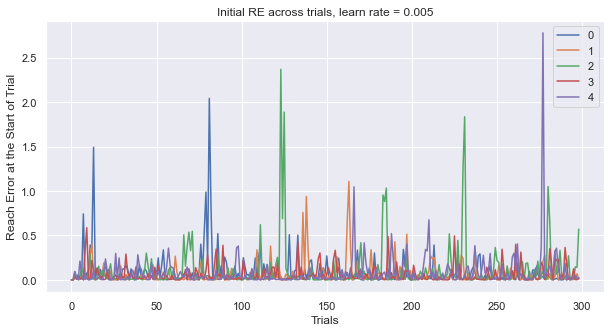

In [10]:
NUM_TRIALS = 300
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trail for target once
NUM_SESSIONS = 5
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [5e-3]
A_RATE = 5e-5
K_RATE = 5e-5
ADAPT_TRIALS = NUM_TRIALS
ADAPT_DEC = False

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
#             print("fr start of trial")
#             print(fr_start)
#             print("lambda start of trial")
#             print(lambda_trial[:, :, iT, iS])

            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
#             print("cost func params = "+ str(cost_func_params))
            re_startT[iT, iS] = error_costFunc(cost_func_params)
#             print("re start = " + str(re_startT[iT, iS]))

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
            print("cursor start = " + str(cursor_start[:, :, iT, iS]) )

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
            fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            
    #         print("fr_run = " + str(fr_run))
#             re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, :, iT], NUM_RUNS)
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
#             print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
            print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        # display stuff
#         print("target position:")
#         print(target_trial)
#         print("cursor end: ")
#         print(cursor_end)
#         print("cursor start: ")
#         print(cursor_start)

        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))
        #     plt.show()
        
#         plt.figure(2*pidx + 2, figsize=(fig_x, fig_y))
#         plt.plot(np.arange(NUM_TRIALS-20-1, NUM_TRIALS-1, 1), re_startT[NUM_TRIALS-1-20:NUM_TRIALS-1, iS])
#         plt.xlabel('Trials' )#, color='white')
#         plt.ylabel('Reach Error at Last 20 Trials')#, color='white')
#         plt.title('Ending RE across trials | learn rate = ' + str(lambda_rate) + '| Decoder Adapt = ' + str(ADAPT_DEC)) #, color = 'white')
#         #     plt.show()

    

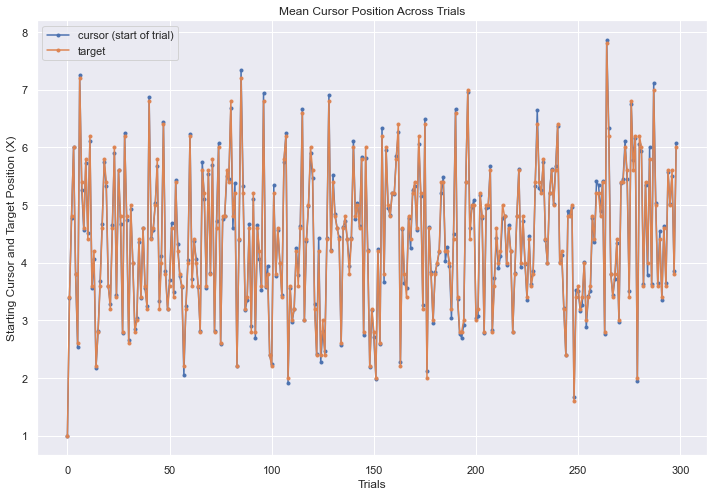

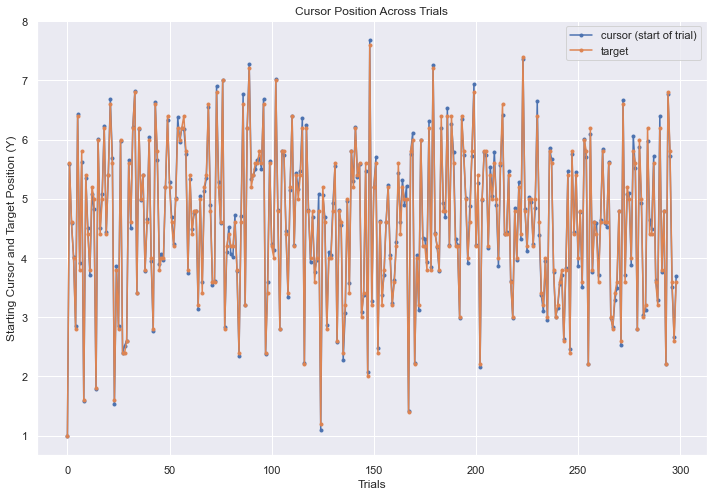

In [11]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Cursor Position Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

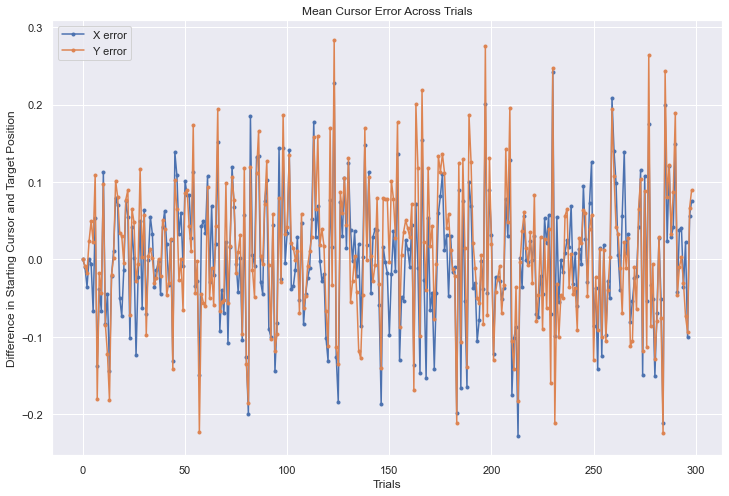

In [12]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

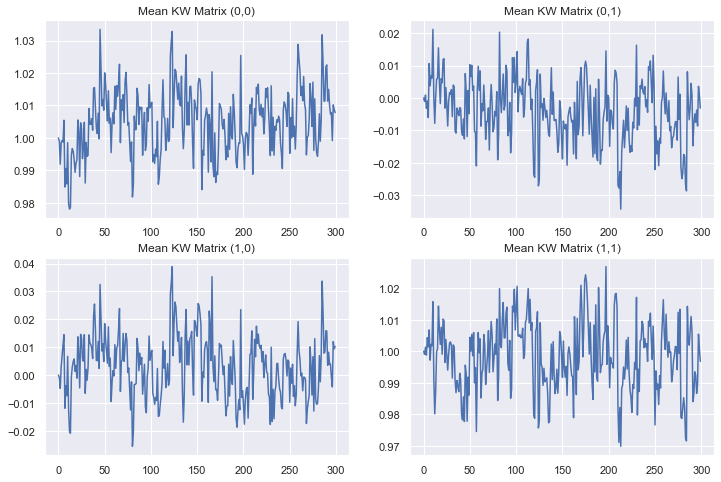

In [13]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

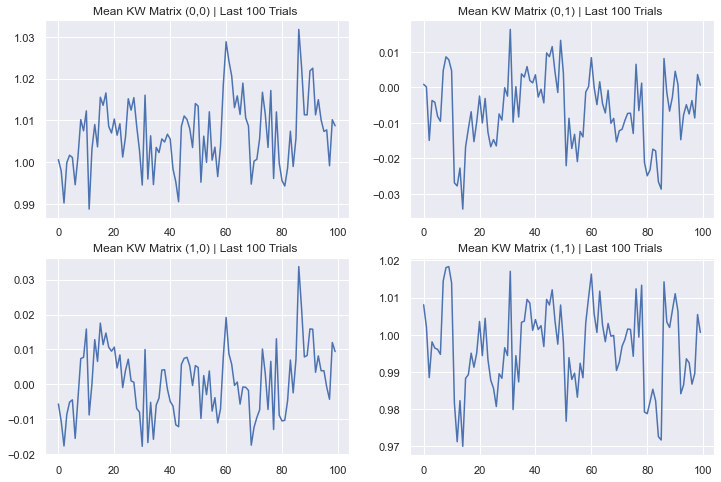

In [14]:

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")

plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-100:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [15]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 0.08745235915894163
Session # 1| RE = 0.06295469881792028
Session # 2| RE = 0.10939155298795486
Session # 3| RE = 0.061888620565282604
Session # 4| RE = 0.08113746611315444
